In [2]:
!pip install imbalanced-learn

     -------------------------------------- 235.6/235.6 kB 2.4 MB/s eta 0:00:00
     ---------------------------------------- 9.3/9.3 MB 6.4 MB/s eta 0:00:00
     -------------------------------------- 302.2/302.2 kB 3.1 MB/s eta 0:00:00
  Attempting uninstall: joblib
    Found existing installation: joblib 0.17.0
    Uninstalling joblib-0.17.0:
      Successfully uninstalled joblib-0.17.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.23.2
    Uninstalling scikit-learn-0.23.2:
      Successfully uninstalled scikit-learn-0.23.2



[notice] A new release of pip available: 22.2.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [83]:
pip install -U threadpoolctl

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


  Attempting uninstall: threadpoolctl
    Found existing installation: threadpoolctl 3.1.0
    Uninstalling threadpoolctl-3.1.0:
      Successfully uninstalled threadpoolctl-3.1.0


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import *
from dateutil.relativedelta import relativedelta
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, PrecisionRecallDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
import imblearn
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from mpl_toolkits.axes_grid1 import ImageGrid
import pickle
import scipy.stats as stats
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence

In [2]:
# reading the CSV file
Opportunity_1 = pd.read_csv("C:/MSDS/classes/DS785/Opportunity_History_1.csv")
Opportunity_2 = pd.read_csv("C:/MSDS/classes/DS785/Opportunity_History_2.csv")
files = ["C:/MSDS/classes/DS785/Opportunity_History_1.csv", "C:/MSDS/classes/DS785/Opportunity_History_2.csv"]
Opportunity_History = pd.concat((pd.read_csv(filename) for filename in files), ignore_index = True)

## Need to filter data for only Non-Nexus Opportunities
Opportunity_History = Opportunity_History[Opportunity_History['Booking_Amount'] <= 50000]
Opportunity_History["Is_EHR"] = np.where(((Opportunity_History["Enterprise_Family"].str.contains('Unity')) |
                                        (Opportunity_History["Enterprise_Family"].str.contains('Evolv')) |
                                        (Opportunity_History["Enterprise_Family"].str.contains('Avatar'))), 1, 0)



In [3]:
print(Opportunity_History.shape)
Opportunity_History.info()

(55054, 48)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 55054 entries, 5 to 173488
Data columns (total 48 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Opportunity_SysID               55054 non-null  object 
 1   Account_SysID                   55054 non-null  object 
 2   Stage                           55054 non-null  object 
 3   Probability                     55054 non-null  int64  
 4   Mgmt_Probability                19730 non-null  float64
 5   Weighted_Probability            55054 non-null  int64  
 6   SPO_Percent                     55054 non-null  int64  
 7   Calculated_Mgmt_Percent         55054 non-null  int64  
 8   Booking_Amount                  55054 non-null  float64
 9   Booking_Amount_Annualized       55054 non-null  float64
 10  Mgmt_Booking_Amount_Annualized  55054 non-null  float64
 11  Is_Closed                       55054 non-null  object 
 12  Is_Won             

In [4]:
## Create Lead Category field
Opportunity_History["Lead_Category"] = np.where((Opportunity_History["Lead_Source"].str.contains('Inbound Calls')), "Inbound Calls", 
                                       np.where((Opportunity_History["Lead_Source"].str.contains('Acquisition')), "Aquisition",
                                       np.where((Opportunity_History["Lead_Source"].str.contains('Demo')), "Demo",
                                       np.where((Opportunity_History["Lead_Source"].str.contains('Cold Call')), "ColdCall/Lead/Tradeshow",
                                       np.where((Opportunity_History["Lead_Source"].str.contains('Paid Leads')), "ColdCall/Lead/Tradeshow", 
                                       np.where((Opportunity_History["Lead_Source"].str.contains('Tradeshow')), "ColdCall/Lead/Tradeshow",
                                       np.where((Opportunity_History["Lead_Source"].str.contains('Contact Us Form')), "Contact Us Form", "Other")))))))

In [5]:
Opportunity_History.columns 
Opportunity_History.Enterprise_Family.value_counts()
Opportunity_History.Lead_Category.value_counts()


Demo                       10884
Other                      10487
Inbound Calls              10217
Aquisition                  8686
ColdCall/Lead/Tradeshow     8588
Contact Us Form             6192
Name: Lead_Category, dtype: int64

In [6]:
## Create column for length of contract and take out BA/BAA
Opportunity_History["Contract_Length"] = Opportunity_History["Booking_Amount"] / Opportunity_History["Booking_Amount_Annualized"]

In [7]:
Opportunity_History.Active_Start_Date
Opportunity_History['Is_Strategic_Deal'] = Opportunity_History['Is_Strategic_Deal'].replace(np.nan, 'No')
Opportunity_History['Is_RFP'] = Opportunity_History['Is_RFP'].replace(np.nan, 'No')
Opportunity_History['Contract_Type'] = Opportunity_History['Contract_Type'].replace(np.nan, 'Other')
Opportunity_History['Push_Count'] = Opportunity_History['Push_Count'].replace(np.nan, 0)

Opportunity_History['Last_Activity'] = Opportunity_History['Last_Activity'].fillna(Opportunity_History['Created_On'])
Opportunity_History.Active_Start_Date
Opportunity_History = Opportunity_History.drop(columns = ["Uplift_or_Rollover_Opportunity", "Stretch_Indicator", "Secondary_Outcome_Reason", "Discount", "Forecast_Category", "Strategic_Pursuit_Type", "Solutions_Development_Date", "Discovery_Stage_Date", "Qualifying_Stage_Date", "Enterprise_Family", "Team", "Primary_Outcome_Reason", "Lead_Source", "Segment", "Opportunity_Type", "Close_Date", "Is_Deleted", "RFP_RFI_Due_Date", "Is_Closed", "Is_Won", "Active_Record", "Price_Discount_Exceptions", "Payment_Due_Upon_Execution", "Probability", "Mgmt_Probability", "Weighted_Probability", "SPO_Percent", "Calculated_Mgmt_Percent", "Account_SysID", "Modified_On", "Win_Loss_Close_Date", "Active_Record", "Active_Start_Time", "Active_End_Time"])

In [8]:
Opportunity_History.Is_Strategic_Deal.value_counts()
Opportunity_History['Push_Count'].isna().sum()
##Opportunity_History = Opportunity_History[Opportunity_History['Contract_Type'] == "New Master Agreement"]
##Opportunity_History = Opportunity_History.drop(columns = ["Contract_Type", "Opportunity_Type", "Segment", "Lead_Source", "Primary_Outcome_Reason", "Team", "Enterprise_Family", "Qualifying_Stage_Date", "Discovery_Stage_Date", "Solutions_Development_Date", "Strategic_Pursuit_Type", "Uplift_or_Rollover_Opportunity", "Last_Activity", "Push_Count"])

0

In [9]:
Opportunity_History = Opportunity_History.reset_index()
Opportunity_History

,index,Opportunity_SysID,Stage,Booking_Amount,Booking_Amount_Annualized,Mgmt_Booking_Amount_Annualized,Contract_Type,Is_RFP,Number_of_Days_in_Stage,Last_Activity,Created_On,Push_Count,Is_Strategic_Deal,Active_Start_Date,Active_End_Date,Is_EHR,Lead_Category,Contract_Length
0,5,0060g00000yIoU1AAK,7 - Closed/Won,8750.0,8750.0,8750.0,New Master Agreement,No,0.0,6/25/2019,6/11/2019 15:38,1.0,No,1/14/2022,1/15/2022,1,Demo,1.0
1,8,0060g00000w38mxAAA,7 - Closed/Won,27596.0,27596.0,27596.0,New Master Agreement,No,0.0,11/8/2018 2:45,11/8/2018 2:45,0.0,No,4/10/2023,12/31/2099,1,Aquisition,1.0
2,16,0067000000TWwfyAAD,Closed Abandoned,0.0,0.0,0.0,Other,No,0.0,12/20/2012,1/26/2013 14:21,0.0,No,4/22/2023,7/18/2023,0,Inbound Calls,NaN
3,29,0067000000TWwnQAAT,Closed Abandoned,0.0,0.0,0.0,Other,No,0.0,10/8/2012,1/26/2013 14:35,0.0,No,4/22/2023,7/18/2023,0,Inbound Calls,NaN
4,43,0067000000TWwnmAAD,Closed Abandoned,0.0,0.0,0.0,Other,No,0.0,10/2/2012,1/26/2013 14:35,0.0,No,4/22/2023,7/18/2023,0,Inbound Calls,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55049,173475,0064u00001B0zcVAAR,Order Abandonment,20775.0,6925.0,0.0,Other,No,0.0,6/8/2022,5/20/2022 20:13,1.0,No,7/27/2023,12/31/2099,1,Other,3.0
55050,173477,0064u00001CC5i6AAD,7 - Closed/Won,7290.0,7290.0,7290.0,New Master Agreement,No,0.0,11/4/2022,8/16/2022 15:18,3.0,No,7/24/2023,7/25/2023,0,Inbound Calls,1.0
55051,173479,0064u00001ClIeSAAV,7 - Closed/Won,22500.0,7500.0,7500.0,New Master Agreement,No,0.0,9/22/2022,9/16/2022 17:53,0.0,No,7/30/2023,7/31/2023,1,Inbound Calls,3.0
55052,173483,0064u00001Aai29AAB,7 - Closed/Won,31050.0,31050.0,31050.0,New Master Agreement,No,0.0,6/30/2022,4/12/2022 20:31,0.0,No,8/7/2023,12/31/2099,0,Demo,1.0


In [10]:
Opportunity_History['Last_Activity'] = pd.to_datetime(Opportunity_History['Last_Activity']).dt.date
Opportunity_History.Active_Start_Date = pd.to_datetime(Opportunity_History['Active_Start_Date']).dt.date
Opportunity_History.Active_End_Date = pd.to_datetime(Opportunity_History['Active_End_Date']).dt.date
##Opportunity_History['Active_End_Date'] = pd.to_datetime(Opportunity_History['Active_End_Date'])
Opportunity_History['Days_Since_Last_Activity'] = (Opportunity_History['Active_End_Date'] - Opportunity_History['Last_Activity']).dt.days
Opportunity_History

,index,Opportunity_SysID,Stage,Booking_Amount,Booking_Amount_Annualized,Mgmt_Booking_Amount_Annualized,Contract_Type,Is_RFP,Number_of_Days_in_Stage,Last_Activity,Created_On,Push_Count,Is_Strategic_Deal,Active_Start_Date,Active_End_Date,Is_EHR,Lead_Category,Contract_Length,Days_Since_Last_Activity
0,5,0060g00000yIoU1AAK,7 - Closed/Won,8750.0,8750.0,8750.0,New Master Agreement,No,0.0,2019-06-25,6/11/2019 15:38,1.0,No,2022-01-14,2022-01-15,1,Demo,1.0,935
1,8,0060g00000w38mxAAA,7 - Closed/Won,27596.0,27596.0,27596.0,New Master Agreement,No,0.0,2018-11-08,11/8/2018 2:45,0.0,No,2023-04-10,2099-12-31,1,Aquisition,1.0,29638
2,16,0067000000TWwfyAAD,Closed Abandoned,0.0,0.0,0.0,Other,No,0.0,2012-12-20,1/26/2013 14:21,0.0,No,2023-04-22,2023-07-18,0,Inbound Calls,NaN,3862
3,29,0067000000TWwnQAAT,Closed Abandoned,0.0,0.0,0.0,Other,No,0.0,2012-10-08,1/26/2013 14:35,0.0,No,2023-04-22,2023-07-18,0,Inbound Calls,NaN,3935
4,43,0067000000TWwnmAAD,Closed Abandoned,0.0,0.0,0.0,Other,No,0.0,2012-10-02,1/26/2013 14:35,0.0,No,2023-04-22,2023-07-18,0,Inbound Calls,NaN,3941
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55049,173475,0064u00001B0zcVAAR,Order Abandonment,20775.0,6925.0,0.0,Other,No,0.0,2022-06-08,5/20/2022 20:13,1.0,No,2023-07-27,2099-12-31,1,Other,3.0,28330
55050,173477,0064u00001CC5i6AAD,7 - Closed/Won,7290.0,7290.0,7290.0,New Master Agreement,No,0.0,2022-11-04,8/16/2022 15:18,3.0,No,2023-07-24,2023-07-25,0,Inbound Calls,1.0,263
55051,173479,0064u00001ClIeSAAV,7 - Closed/Won,22500.0,7500.0,7500.0,New Master Agreement,No,0.0,2022-09-22,9/16/2022 17:53,0.0,No,2023-07-30,2023-07-31,1,Inbound Calls,3.0,312
55052,173483,0064u00001Aai29AAB,7 - Closed/Won,31050.0,31050.0,31050.0,New Master Agreement,No,0.0,2022-06-30,4/12/2022 20:31,0.0,No,2023-08-07,2099-12-31,0,Demo,1.0,28308


In [11]:
Opportunity_History.dtypes

index                               int64
Opportunity_SysID                  object
Stage                              object
Booking_Amount                    float64
Booking_Amount_Annualized         float64
Mgmt_Booking_Amount_Annualized    float64
Contract_Type                      object
Is_RFP                             object
Number_of_Days_in_Stage           float64
Last_Activity                      object
Created_On                         object
Push_Count                        float64
Is_Strategic_Deal                  object
Active_Start_Date                  object
Active_End_Date                    object
Is_EHR                              int32
Lead_Category                      object
Contract_Length                   float64
Days_Since_Last_Activity            int64
dtype: object

In [12]:
Opportunity_History.Active_Start_Date = pd.to_datetime(Opportunity_History['Active_Start_Date']).dt.date
Opportunity_History.Active_End_Date = pd.to_datetime(Opportunity_History['Active_End_Date']).dt.date
start_plus1 = Opportunity_History.Active_Start_Date[0]
start_plus1 = start_plus1 + relativedelta(months = 1)
start_plus1

datetime.date(2022, 2, 14)

In [13]:
## Creating master dataframe to fill in
masterfile = pd.DataFrame()

In [14]:
## Getting Stage 3 months later
start_date = "01-01-2019"
end_date = "04-01-2019"
start_date = datetime.strptime(start_date, "%m-%d-%Y").date()
end_date = datetime.strptime(end_date, "%m-%d-%Y").date()
term_date = "2-01-2023"
term_date = datetime.strptime(term_date, "%m-%d-%Y").date()

In [15]:
masterfile = pd.DataFrame()
while start_date < term_date:
# Creating a new dataframe based on the conditions
    new_dataframe = Opportunity_History[
        (Opportunity_History['Active_Start_Date'] <= start_date) &
        (Opportunity_History['Active_End_Date'] > start_date) &
        (~Opportunity_History['Stage'].str.contains('Closed')) &
        (~Opportunity_History['Stage'].str.contains('Abandonment')) & 
        (Opportunity_History['Booking_Amount'] > 0)
    ][[
        'Opportunity_SysID', 'Stage', 'Booking_Amount',
        'Booking_Amount_Annualized', 'Mgmt_Booking_Amount_Annualized', 'Contract_Type', 
        'Is_RFP', 'Number_of_Days_in_Stage', 'Push_Count', "Is_EHR", "Lead_Category",
        'Is_Strategic_Deal', 'Active_Start_Date', 'Active_End_Date', 'Days_Since_Last_Activity', 'Contract_Length'
    ]]

    # Adding the 'end_stage' column
    end_stage_conditions = (
        (Opportunity_History['Active_Start_Date'] <= end_date) &
        (Opportunity_History['Active_End_Date'] > end_date)
    )
    end_stage_mapping = Opportunity_History.loc[end_stage_conditions, ['Opportunity_SysID', 'Stage']].set_index('Opportunity_SysID')['Stage']
    new_dataframe['end_stage'] = new_dataframe['Opportunity_SysID'].map(end_stage_mapping)
    masterfile = pd.concat([masterfile, new_dataframe])
    start_date = start_date + relativedelta(months = 1)
    end_date = end_date + relativedelta(months = 1)
# Print the new dataframe

In [16]:
closed = masterfile[masterfile['end_stage'] == '7 - Closed/Won']
closed
masterfile['end_stage'] = masterfile['end_stage'].replace(np.nan, "None")

In [17]:
Opportunity_History[
    (Opportunity_History['Active_Start_Date'] <= end_date) &
    (Opportunity_History['Active_End_Date'] > end_date) &
    (Opportunity_History['Opportunity_SysID'] == "0064u000013m1SYAAY")]

,index,Opportunity_SysID,Stage,Booking_Amount,Booking_Amount_Annualized,Mgmt_Booking_Amount_Annualized,Contract_Type,Is_RFP,Number_of_Days_in_Stage,Last_Activity,Created_On,Push_Count,Is_Strategic_Deal,Active_Start_Date,Active_End_Date,Is_EHR,Lead_Category,Contract_Length,Days_Since_Last_Activity


In [18]:
masterfile

,Opportunity_SysID,Stage,Booking_Amount,Booking_Amount_Annualized,Mgmt_Booking_Amount_Annualized,Contract_Type,Is_RFP,Number_of_Days_in_Stage,Push_Count,Is_EHR,Lead_Category,Is_Strategic_Deal,Active_Start_Date,Active_End_Date,Days_Since_Last_Activity,Contract_Length,end_stage
457,0064u000013n1LmAAI,3 - Short-Listed,20895.12,6965.04,2089.51,New Master Agreement,No,0.0,3.0,1,Demo,No,2020-12-01,2020-12-22,61,3.000000,Closed Companion
519,0064u000013njFiAAI,2 - Solution Development,17100.00,17100.00,2565.00,New Master Agreement,No,0.0,1.0,1,Demo,No,2020-11-11,2021-01-12,63,1.000000,2 - Solution Development
653,0060g00000zd4zYAAQ,1 - Discovery,28500.00,28500.00,0.00,New Master Agreement,No,0.0,3.0,1,ColdCall/Lead/Tradeshow,No,2020-12-01,2021-01-08,39,1.000000,1 - Discovery
656,0060g00000vbni8AAA,2 - Solution Development,28700.00,28700.00,5166.00,New Master Agreement,No,0.0,0.0,1,Other,No,2020-12-01,2020-12-05,5,1.000000,Closed Abandoned
1421,0060g00000yw9CXAAY,1 - Discovery,26000.00,26000.00,6500.00,New Master Agreement,No,0.0,13.0,1,Contact Us Form,No,2020-11-05,2021-01-14,79,1.000000,1 - Discovery
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54114,0064u00001C8UqIAAV,2 - Solution Development,1500.00,1500.00,0.00,Quote Addendum,No,150.0,1.0,0,Aquisition,No,2022-12-17,2023-01-15,179,1.000000,2 - Solution Development
54394,0064u00001DXg4gAAD,1 - Discovery,36532.08,12177.36,0.00,Other,No,12.0,0.0,1,Other,No,2022-12-13,2023-01-15,46,3.000000,Order Abandonment
54502,0064u00001D4fBOAAZ,2 - Solution Development,40407.12,13469.04,2693.81,Other,No,0.0,0.0,1,Demo,No,2022-11-01,2023-01-15,79,3.000000,2 - Solution Development
54508,0064u00001BoziFAAR,1 - Discovery,22500.00,10500.00,0.00,Other,No,112.0,0.0,1,Demo,No,2022-12-15,2023-01-15,32,2.142857,1 - Discovery


In [19]:
masterfile.dtypes

Opportunity_SysID                  object
Stage                              object
Booking_Amount                    float64
Booking_Amount_Annualized         float64
Mgmt_Booking_Amount_Annualized    float64
Contract_Type                      object
Is_RFP                             object
Number_of_Days_in_Stage           float64
Push_Count                        float64
Is_EHR                              int32
Lead_Category                      object
Is_Strategic_Deal                  object
Active_Start_Date                  object
Active_End_Date                    object
Days_Since_Last_Activity            int64
Contract_Length                   float64
end_stage                          object
dtype: object

In [20]:
## Convert Objects to categorical type
masterfile["Stage"] = masterfile["Stage"].astype("category")
masterfile["Contract_Type"] = masterfile["Contract_Type"].astype("category")
masterfile["Is_RFP"] = masterfile["Is_RFP"].astype("category")
masterfile["Is_Strategic_Deal"] = masterfile["Is_Strategic_Deal"].astype("category")
masterfile["end_stage"] = masterfile["end_stage"].astype("category")
masterfile["Lead_Category"] = masterfile["Lead_Category"].astype("category")

In [21]:
## Getting count of NA values
nan_count = masterfile.isna().sum()
print(nan_count)

## removing all rows where end_stage is NA
#masterfile = masterfile.dropna(subset=['end_stage'], inplace=True)

Opportunity_SysID                 0
Stage                             0
Booking_Amount                    0
Booking_Amount_Annualized         0
Mgmt_Booking_Amount_Annualized    0
Contract_Type                     0
Is_RFP                            0
Number_of_Days_in_Stage           0
Push_Count                        0
Is_EHR                            0
Lead_Category                     0
Is_Strategic_Deal                 0
Active_Start_Date                 0
Active_End_Date                   0
Days_Since_Last_Activity          0
Contract_Length                   0
end_stage                         0
dtype: int64


Text(0.5, 1.0, 'Days_Since_Last_Activity')

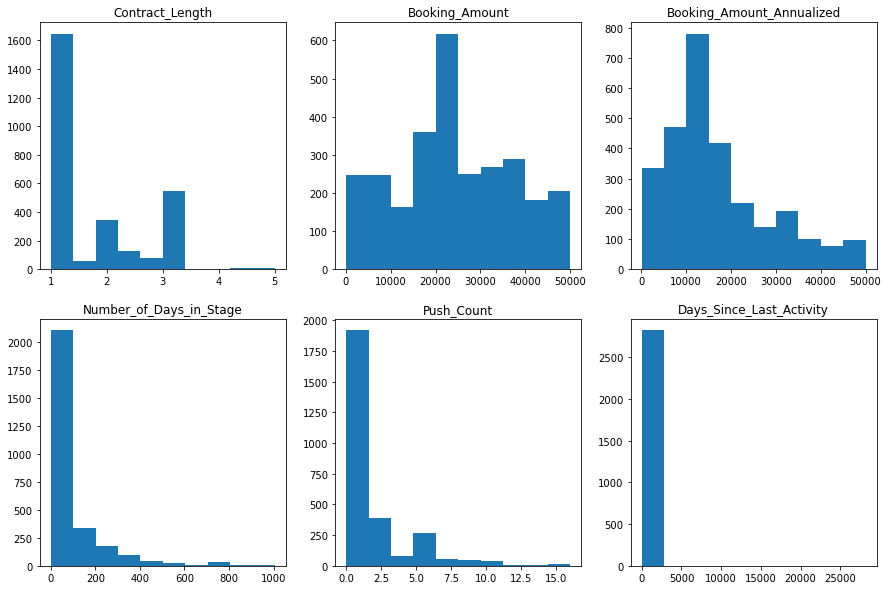

In [24]:
fig, axs = plt.subplots(2, 3)
fig.set_figheight(10)
fig.set_figwidth(15)

axs[0,0].hist(data = masterfile, x = 'Contract_Length')
axs[0,0].set_title('Contract_Length')
axs[0,1].hist(data = masterfile, x = 'Booking_Amount')
axs[0,1].set_title('Booking_Amount')
axs[0,2].hist(data = masterfile, x = 'Booking_Amount_Annualized')
axs[0,2].set_title('Booking_Amount_Annualized')
axs[1,0].hist(data = masterfile, x = 'Number_of_Days_in_Stage')
axs[1,0].set_title('Number_of_Days_in_Stage')
axs[1,1].hist(data = masterfile, x = 'Push_Count')
axs[1,1].set_title('Push_Count')
axs[1,2].hist(data = masterfile, x = 'Days_Since_Last_Activity')
axs[1,2].set_title('Days_Since_Last_Activity')

#masterfile.hist(column = 'Days_Since_Last_Activity')

In [26]:
masterfile = masterfile.reset_index()

In [27]:
## one hot encode categorical variables
cat_encoder = OneHotEncoder(sparse=False)
columns_to_encode = ['Stage', 'Contract_Type', 'Is_RFP', 'Is_Strategic_Deal', "Lead_Category"]
encoded_array = cat_encoder.fit_transform(masterfile.loc[:, columns_to_encode])
df_encoded = pd.DataFrame(encoded_array, columns = cat_encoder.get_feature_names_out())
##df_sklearn_encoded = pd.concat([masterfile, df_encoded], axis=1)
##df_sklearn_encoded = masterfile.join(df_encoded)
df_sklearn_encoded = pd.merge(masterfile, df_encoded, left_index=True, right_index=True)
df_sklearn_encoded.drop(columns = ['Stage', 'Contract_Type', 'Is_RFP', 'Is_Strategic_Deal', 'Lead_Category'], axis=1, inplace=True)
df_sklearn_encoded

C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,index,Opportunity_SysID,Booking_Amount,Booking_Amount_Annualized,Mgmt_Booking_Amount_Annualized,Number_of_Days_in_Stage,Push_Count,Is_EHR,Active_Start_Date,Active_End_Date,...,Is_RFP_No,Is_RFP_Yes,Is_Strategic_Deal_No,Is_Strategic_Deal_Yes,Lead_Category_Aquisition,Lead_Category_ColdCall/Lead/Tradeshow,Lead_Category_Contact Us Form,Lead_Category_Demo,Lead_Category_Inbound Calls,Lead_Category_Other
0,457,0064u000013n1LmAAI,20895.12,6965.04,2089.51,0.0,3.0,1,2020-12-01,2020-12-22,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,519,0064u000013njFiAAI,17100.00,17100.00,2565.00,0.0,1.0,1,2020-11-11,2021-01-12,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,653,0060g00000zd4zYAAQ,28500.00,28500.00,0.00,0.0,3.0,1,2020-12-01,2021-01-08,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,656,0060g00000vbni8AAA,28700.00,28700.00,5166.00,0.0,0.0,1,2020-12-01,2020-12-05,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1421,0060g00000yw9CXAAY,26000.00,26000.00,6500.00,0.0,13.0,1,2020-11-05,2021-01-14,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2819,54114,0064u00001C8UqIAAV,1500.00,1500.00,0.00,150.0,1.0,0,2022-12-17,2023-01-15,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2820,54394,0064u00001DXg4gAAD,36532.08,12177.36,0.00,12.0,0.0,1,2022-12-13,2023-01-15,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2821,54502,0064u00001D4fBOAAZ,40407.12,13469.04,2693.81,0.0,0.0,1,2022-11-01,2023-01-15,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2822,54508,0064u00001BoziFAAR,22500.00,10500.00,0.00,112.0,0.0,1,2022-12-15,2023-01-15,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [28]:
df_sklearn_encoded['Booking_Amount_Annualized_sqr'] = df_sklearn_encoded['Booking_Amount_Annualized']**2
df_sklearn_encoded['Booking_Amount_Annualized_log'] = np.log(df_sklearn_encoded['Booking_Amount_Annualized']+0.1)
df_sklearn_encoded['Booking_Amount_Annualized_sqrt'] = np.sqrt(df_sklearn_encoded['Booking_Amount_Annualized']+0.1)
df_sklearn_encoded['Mgmt_Booking_Amount_Annualized_log'] = np.log(df_sklearn_encoded['Mgmt_Booking_Amount_Annualized']+0.1)
df_sklearn_encoded['Mgmt_Booking_Amount_Annualized_sqr'] = df_sklearn_encoded['Mgmt_Booking_Amount_Annualized']**2
df_sklearn_encoded['Mgmt_Booking_Amount_Annualized_sqrt'] = np.sqrt(df_sklearn_encoded['Mgmt_Booking_Amount_Annualized'])
df_sklearn_encoded['Number_of_Days_in_Stage_log'] = np.log(df_sklearn_encoded['Number_of_Days_in_Stage']+0.1)
df_sklearn_encoded['Number_of_Days_in_Stage_sqrt'] = np.sqrt(df_sklearn_encoded['Number_of_Days_in_Stage']+0.1)
df_sklearn_encoded['Number_of_Days_in_Stage_sqr'] = df_sklearn_encoded['Number_of_Days_in_Stage']**2
df_sklearn_encoded['Push_Count_log'] = np.log(df_sklearn_encoded['Push_Count']+0.1)
df_sklearn_encoded['Push_Count_sqr'] = df_sklearn_encoded['Push_Count']**2
df_sklearn_encoded['Push_Count_sqrt'] = np.sqrt(df_sklearn_encoded['Push_Count']+0.1)
df_sklearn_encoded['Contract_Length_log'] = np.log(df_sklearn_encoded['Contract_Length']+0.1)
df_sklearn_encoded['Contract_Length_sqr'] = df_sklearn_encoded['Contract_Length']**2
df_sklearn_encoded['Contract_Length_sqrt'] = np.sqrt(df_sklearn_encoded['Contract_Length']+0.1)
df_sklearn_encoded['Days_Since_Last_Activity_log'] = np.log(df_sklearn_encoded['Days_Since_Last_Activity']+0.1)
df_sklearn_encoded['Days_Since_Last_Activity_sqr'] = df_sklearn_encoded['Days_Since_Last_Activity']**2
df_sklearn_encoded['Days_Since_Last_Activity_sqrt'] = np.sqrt(df_sklearn_encoded['Days_Since_Last_Activity']+0.1)

C:\Users\nbrow\Downloads\anaconda\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\nbrow\Downloads\anaconda\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


array([[<AxesSubplot:title={'center':'Days_Since_Last_Activity_sqrt'}>]],
      dtype=object)

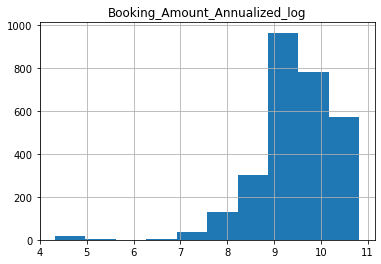

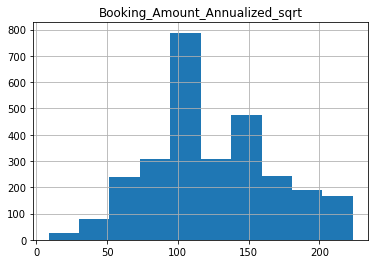

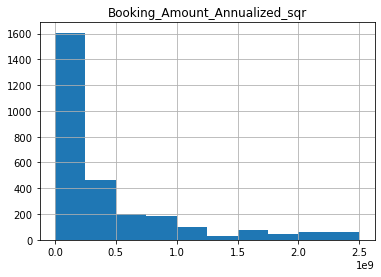

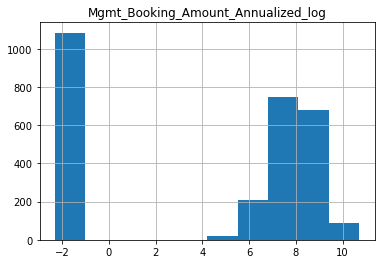

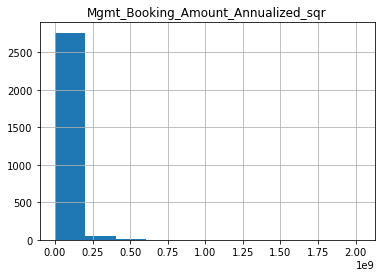

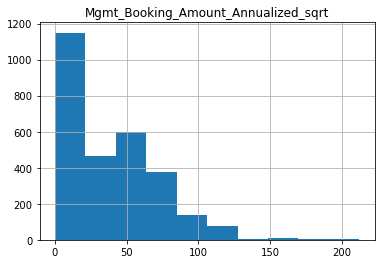

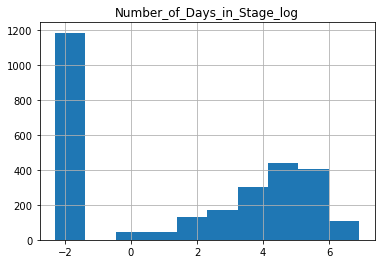

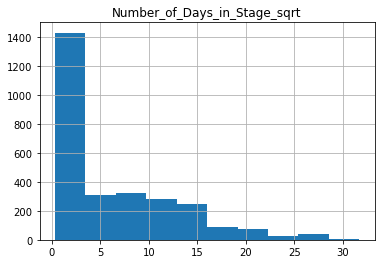

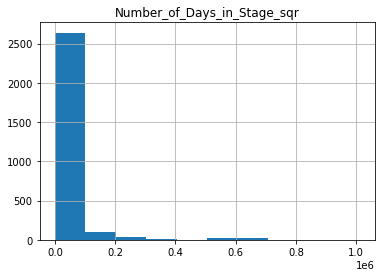

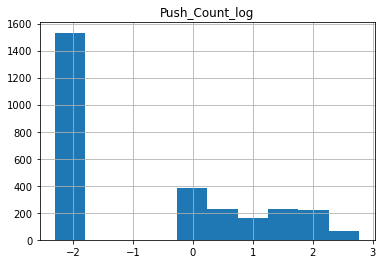

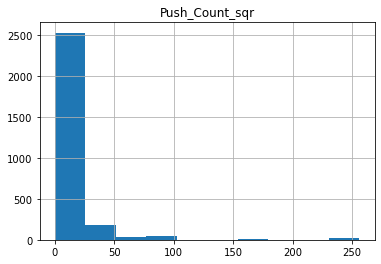

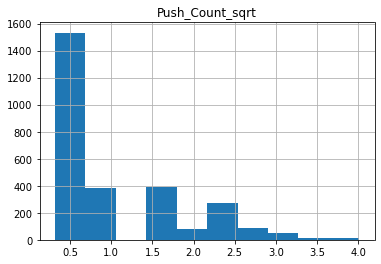

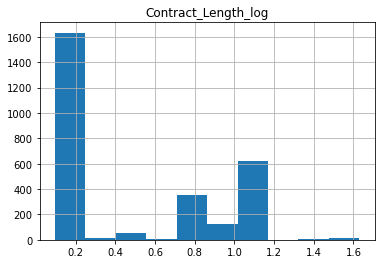

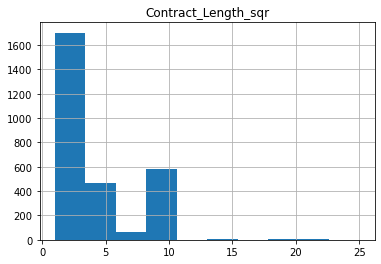

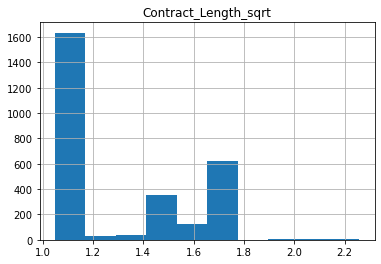

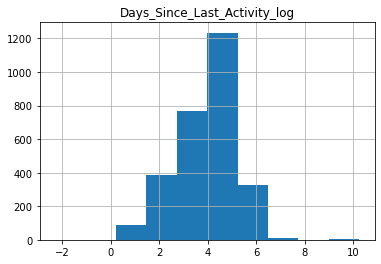

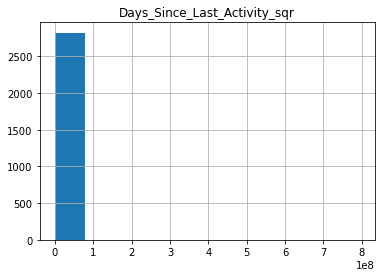

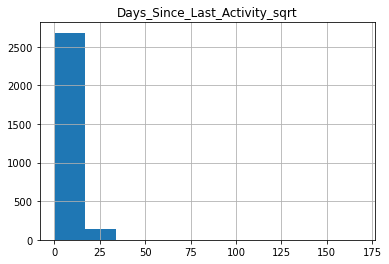

In [29]:
##data_normalize = normalize()
##df_sklearn_encoded['Booking_Amount_Annualized_sqrt'] = preprocessing.normalize(['Booking_Amount_Annualized'])
df_sklearn_encoded.hist(column = 'Booking_Amount_Annualized_log')
df_sklearn_encoded.hist(column = 'Booking_Amount_Annualized_sqrt')
df_sklearn_encoded.hist(column = 'Booking_Amount_Annualized_sqr')
df_sklearn_encoded.hist(column = 'Mgmt_Booking_Amount_Annualized_log')
df_sklearn_encoded.hist(column = 'Mgmt_Booking_Amount_Annualized_sqr')
df_sklearn_encoded.hist(column = 'Mgmt_Booking_Amount_Annualized_sqrt')
df_sklearn_encoded.hist(column = 'Number_of_Days_in_Stage_log')
df_sklearn_encoded.hist(column = 'Number_of_Days_in_Stage_sqrt')
df_sklearn_encoded.hist(column = 'Number_of_Days_in_Stage_sqr')
df_sklearn_encoded.hist(column = 'Push_Count_log')
df_sklearn_encoded.hist(column = 'Push_Count_sqr')
df_sklearn_encoded.hist(column = 'Push_Count_sqrt')
df_sklearn_encoded.hist(column = 'Contract_Length_log')
df_sklearn_encoded.hist(column = 'Contract_Length_sqr')
df_sklearn_encoded.hist(column = 'Contract_Length_sqrt')
df_sklearn_encoded.hist(column = 'Days_Since_Last_Activity_log')
df_sklearn_encoded.hist(column = 'Days_Since_Last_Activity_sqr')
df_sklearn_encoded.hist(column = 'Days_Since_Last_Activity_sqrt')

### The abundance of zeros makes it difficult to normalize the data. Therefore, I will use non-parametric models

Text(0.5, 1.0, 'Days_Since_Last_Activity_sqr')

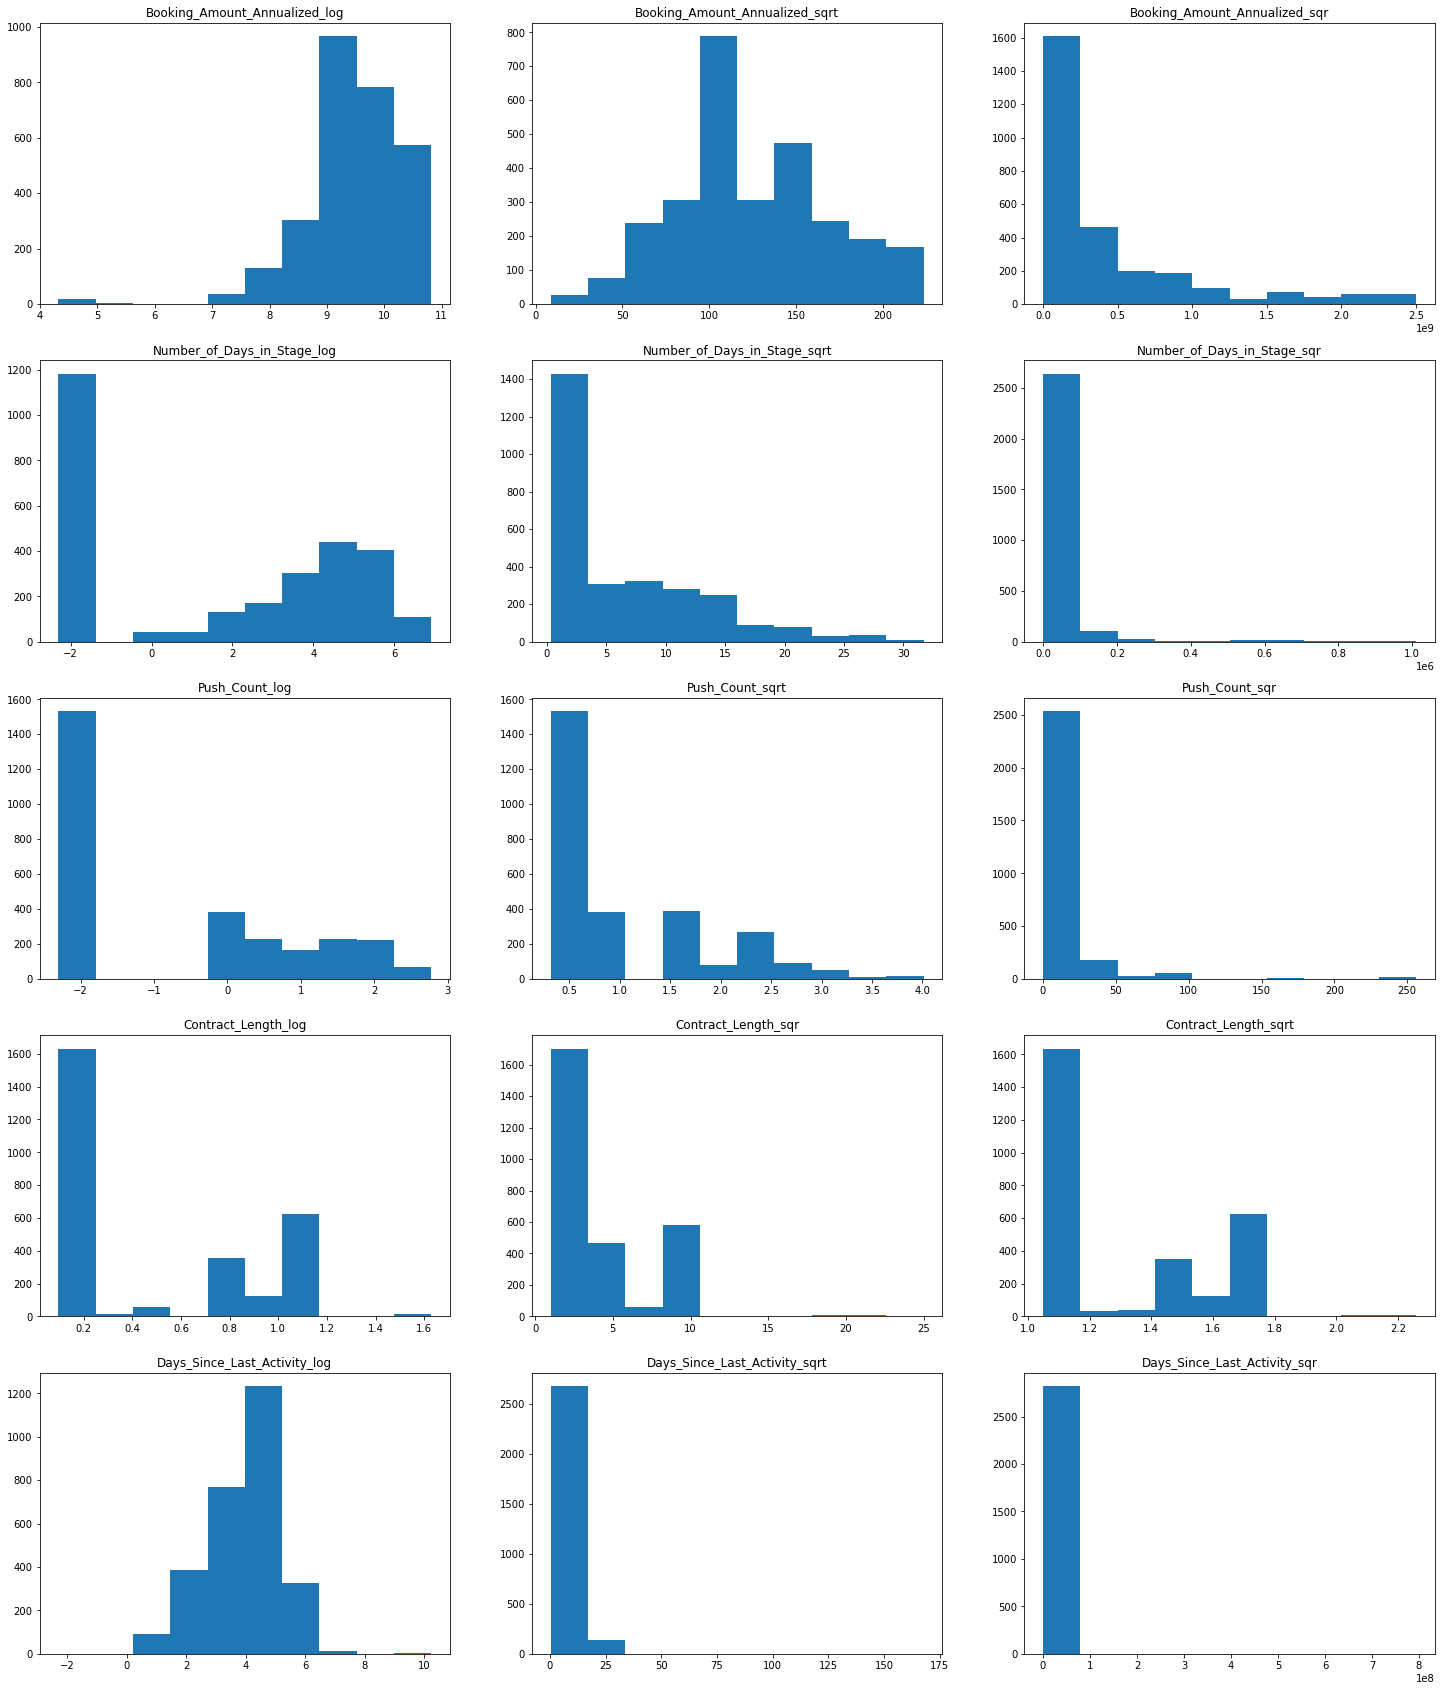

In [30]:
fig, axs = plt.subplots(5, 3)
fig.set_figheight(30)
fig.set_figwidth(25)

axs[0,0].hist(data = df_sklearn_encoded, x = 'Booking_Amount_Annualized_log')
axs[0,0].set_title('Booking_Amount_Annualized_log')
axs[0,1].hist(data = df_sklearn_encoded, x = 'Booking_Amount_Annualized_sqrt')
axs[0,1].set_title('Booking_Amount_Annualized_sqrt')
axs[0,2].hist(data = df_sklearn_encoded, x = 'Booking_Amount_Annualized_sqr')
axs[0,2].set_title('Booking_Amount_Annualized_sqr')
axs[1,0].hist(data = df_sklearn_encoded, x = 'Number_of_Days_in_Stage_log')
axs[1,0].set_title('Number_of_Days_in_Stage_log')
axs[1,1].hist(data = df_sklearn_encoded, x = 'Number_of_Days_in_Stage_sqrt')
axs[1,1].set_title('Number_of_Days_in_Stage_sqrt')
axs[1,2].hist(data = df_sklearn_encoded, x = 'Number_of_Days_in_Stage_sqr')
axs[1,2].set_title('Number_of_Days_in_Stage_sqr')
axs[2,0].hist(data = df_sklearn_encoded, x = 'Push_Count_log')
axs[2,0].set_title('Push_Count_log')
axs[2,1].hist(data = df_sklearn_encoded, x = 'Push_Count_sqrt')
axs[2,1].set_title('Push_Count_sqrt')
axs[2,2].hist(data = df_sklearn_encoded, x = 'Push_Count_sqr')
axs[2,2].set_title('Push_Count_sqr')
axs[3,0].hist(data = df_sklearn_encoded, x = 'Contract_Length_log')
axs[3,0].set_title('Contract_Length_log')
axs[3,1].hist(data = df_sklearn_encoded, x = 'Contract_Length_sqr')
axs[3,1].set_title('Contract_Length_sqr')
axs[3,2].hist(data = df_sklearn_encoded, x = 'Contract_Length_sqrt')
axs[3,2].set_title('Contract_Length_sqrt')
axs[4,0].hist(data = df_sklearn_encoded, x = 'Days_Since_Last_Activity_log')
axs[4,0].set_title('Days_Since_Last_Activity_log')
axs[4,1].hist(data = df_sklearn_encoded, x = 'Days_Since_Last_Activity_sqrt')
axs[4,1].set_title('Days_Since_Last_Activity_sqrt')
axs[4,2].hist(data = df_sklearn_encoded, x = 'Days_Since_Last_Activity_sqr')
axs[4,2].set_title('Days_Since_Last_Activity_sqr')

In [31]:
df_sklearn_encoded.dtypes

index                                       int64
Opportunity_SysID                          object
Booking_Amount                            float64
Booking_Amount_Annualized                 float64
Mgmt_Booking_Amount_Annualized            float64
Number_of_Days_in_Stage                   float64
Push_Count                                float64
Is_EHR                                      int32
Active_Start_Date                          object
Active_End_Date                            object
Days_Since_Last_Activity                    int64
Contract_Length                           float64
end_stage                                category
Stage_0 - Qualifying                      float64
Stage_1 - Discovery                       float64
Stage_2 - Solution Development            float64
Stage_3 - Short-Listed                    float64
Stage_4 - Selected                        float64
Stage_5 - Negotiation                     float64
Stage_6 - Order Processing                float64


In [75]:
df_sklearn_encoded['end_stage_binary'] = df_sklearn_encoded.end_stage.apply(lambda x: 1 if x == "7 - Closed/Won" else 0)

y = df_sklearn_encoded['end_stage_binary']
X = df_sklearn_encoded.drop(columns = ['Booking_Amount_Annualized_sqr', 'Mgmt_Booking_Amount_Annualized','Mgmt_Booking_Amount_Annualized_sqrt', 'Mgmt_Booking_Amount_Annualized_log',
                                        'Mgmt_Booking_Amount_Annualized_sqr', 'Number_of_Days_in_Stage_sqrt', 'Push_Count_sqrt', 'Active_Start_Date',
                                        'Active_End_Date','Opportunity_SysID', 'end_stage', 'end_stage_binary', 'index',
                                        'Number_of_Days_in_Stage_log', 'Number_of_Days_in_Stage_sqrt', 'Number_of_Days_in_Stage_sqr',
                                        'Push_Count_log', 'Push_Count_sqr', 'Push_Count_sqrt', 'Contract_Length_log', 'Contract_Length_sqr', 'Contract_Length_sqrt',
                                        'Days_Since_Last_Activity_log', 'Days_Since_Last_Activity_sqr', 'Days_Since_Last_Activity_sqrt', 'Booking_Amount_Annualized_sqrt', 'Booking_Amount_Annualized_log'])
## Creating Training and test data sets
X_train, X_test, y_train, y_test = train_test_split(
             X, y, test_size = 0.3, random_state = 123)

In [76]:
X

,Booking_Amount,Booking_Amount_Annualized,Number_of_Days_in_Stage,Push_Count,Is_EHR,Days_Since_Last_Activity,Contract_Length,Stage_0 - Qualifying,Stage_1 - Discovery,Stage_2 - Solution Development,...,Is_RFP_No,Is_RFP_Yes,Is_Strategic_Deal_No,Is_Strategic_Deal_Yes,Lead_Category_Aquisition,Lead_Category_ColdCall/Lead/Tradeshow,Lead_Category_Contact Us Form,Lead_Category_Demo,Lead_Category_Inbound Calls,Lead_Category_Other
0,20895.12,6965.04,0.0,3.0,1,61,3.000000,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,17100.00,17100.00,0.0,1.0,1,63,1.000000,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,28500.00,28500.00,0.0,3.0,1,39,1.000000,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,28700.00,28700.00,0.0,0.0,1,5,1.000000,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,26000.00,26000.00,0.0,13.0,1,79,1.000000,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2819,1500.00,1500.00,150.0,1.0,0,179,1.000000,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2820,36532.08,12177.36,12.0,0.0,1,46,3.000000,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2821,40407.12,13469.04,0.0,0.0,1,79,3.000000,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2822,22500.00,10500.00,112.0,0.0,1,32,2.142857,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [89]:
##RandomForestClassifier
##rfc = RandomForestClassifier(n_estimators=10)
### Do a grid search for KNN parameters
rfc_params = [{'n_estimators': list(range(60,140,20)),
               'criterion': ['gini', 'entropy'], 
               'min_samples_split': list(range(1,4)), 
               'max_features': ['sqrt', 'log2'],
               'bootstrap': [True, False],
               'warm_start': [True, False]}]
rfc_grid = GridSearchCV(RandomForestClassifier(), rfc_params, cv = 10, scoring='f1')

rfc_grid.fit(X_train, y_train)

print(rfc_grid.best_params_)

print(rfc_grid.best_score_)
Random_Forest_f1_Scores = cross_val_score(rfc_grid.best_estimator_, X_train, y_train, cv=10)

#confusion matrix from training data
y_train_pred = cross_val_predict(rfc_grid.best_estimator_, X_train, y_train, cv=10)
cm = confusion_matrix(y_train, y_train_pred)
print(cm)

# Confusion matrix using test data
rfc_grid.score(X_test, y_test)
y_test_pred = cross_val_predict(rfc_grid.best_estimator_, X_test, y_test, cv=10)
cm = confusion_matrix(y_test, y_test_pred)
print(cm)

Random_Forest_f1_file = 'Random_Forest_f1.sav'
pickle.dump(rfc_grid.best_estimator_, open(Random_Forest_f1_file, 'wb'))

C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
640 fits failed out of a total of 1920.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
640 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\

{'bootstrap': False, 'criterion': 'gini', 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 120, 'warm_start': False}
0.4942988505747127
[[1801   24]
 [  95   56]]
[[775   4]
 [ 46  23]]


In [90]:
Random_Forest_f1_Scores = cross_val_score(rfc_grid.best_estimator_, X_train, y_train, cv=10)
Random_Forest_f1_Scores

array([0.94949495, 0.93434343, 0.92929293, 0.96464646, 0.93939394,
       0.91414141, 0.96446701, 0.93908629, 0.94416244, 0.94416244])

C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
640 fits failed out of a total of 1920.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
640 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\

{'bootstrap': True, 'criterion': 'gini', 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 100, 'warm_start': False}
0.8102380952380951
[[1811   14]
 [ 102   49]]


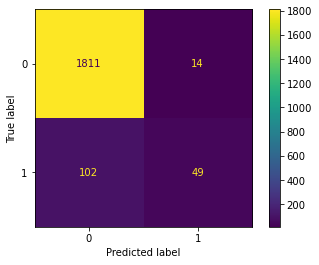

[[778   1]
 [ 49  20]]


In [91]:
## Random forest opimizing for precision (conservative estimate)
rfc_params = [{'n_estimators': list(range(60,140,20)),
               'criterion': ['gini', 'entropy'], 
               'min_samples_split': list(range(1,4)), 
               'max_features': ['sqrt', 'log2'],
               'bootstrap': [True, False],
               'warm_start': [True, False]}]
rfc_grid = GridSearchCV(RandomForestClassifier(), rfc_params, cv = 10, scoring='precision')

rfc_grid.fit(X_train, y_train)

print(rfc_grid.best_params_)

print(rfc_grid.best_score_)

Random_Forest_precision_Scores = cross_val_score(rfc_grid.best_estimator_, X_train, y_train, cv=10)

y_train_pred = cross_val_predict(rfc_grid.best_estimator_, X_train, y_train, cv=10)
cm = confusion_matrix(y_train, y_train_pred)
print(cm)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rfc_grid.classes_)
cm_disp.plot()
plt.show()

# Confusion matrix using test data
rfc_grid.score(X_test, y_test)
y_test_pred = cross_val_predict(rfc_grid.best_estimator_, X_test, y_test, cv=10)
cm = confusion_matrix(y_test, y_test_pred)
print(cm)

Random_Forest_precision_file = 'Random_Forest_precision.sav'
pickle.dump(rfc_grid.best_estimator_, open(Random_Forest_precision_file, 'wb'))

In [92]:
## Random forest opimizing for recall (Liberal estimate)
rfc_params = [{'n_estimators': list(range(60,140,20)),
               'criterion': ['gini', 'entropy'], 
               'min_samples_split': list(range(1,4)), 
               'max_features': ['sqrt', 'log2'],
               'bootstrap': [True, False],
               'warm_start': [True, False]}]
rfc_grid_recall = GridSearchCV(RandomForestClassifier(), rfc_params, cv = 10, scoring='recall')

rfc_grid_recall.fit(X_train, y_train)

print(rfc_grid_recall.best_params_)

print(rfc_grid_recall.best_score_)

Random_Forest_recall_Scores = cross_val_score(rfc_grid_recall.best_estimator_, X_train, y_train, cv=10)

y_train_pred = cross_val_predict(rfc_grid_recall.best_estimator_, X_train, y_train, cv=10)
cm = confusion_matrix(y_train, y_train_pred)
print(cm)

rfc_grid_recall.score(X_test, y_test)
y_test_pred = cross_val_predict(rfc_grid_recall.best_estimator_, X_test, y_test, cv=10)
cm = confusion_matrix(y_test, y_test_pred)
print(cm)

Random_Forest_recall_file = 'Random_Forest_recall.sav'
pickle.dump(rfc_grid_recall.best_estimator_, open(Random_Forest_recall_file, 'wb'))

C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
640 fits failed out of a total of 1920.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
640 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\

{'bootstrap': False, 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 120, 'warm_start': True}
0.39875000000000005
[[1798   27]
 [  98   53]]
[[774   5]
 [ 44  25]]


[[770   9]
 [ 37  32]]


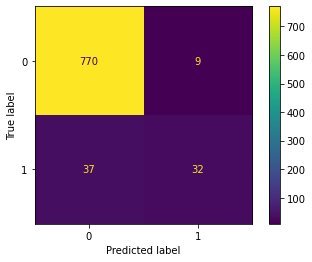

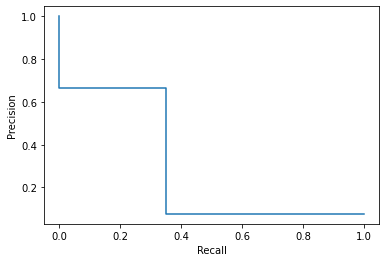

array([[777,   2],
       [ 54,  15]], dtype=int64)

In [93]:
## Creating confusion matrix from test data
y_test_pred = rfc_grid_recall.best_estimator_.predict(X_test)
cm = confusion_matrix(y_test, y_test_pred)
print(cm)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rfc_grid.classes_)
cm_disp.plot()
plt.show()

precision, recall,thresholds_ = precision_recall_curve(y_train, y_train_pred)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.show()

threshold = 0.75
y_pred = (rfc_grid_recall.best_estimator_.predict_proba(X_test)[:, 1] > threshold).astype('float')
confusion_matrix(y_test, y_pred)

In [94]:
## Testing range of thresholds for recall model
Threshold_list = list(np.arange(0.1, 1.0, 0.05))
recall_values = []
threshold_values = []
scores = {}
for i in Threshold_list:
    y_pred = (rfc_grid_recall.best_estimator_.predict_proba(X_test)[:, 1] > i).astype('float')
    cm = confusion_matrix(y_test, y_pred) 
    recall = cm[1][0]/(cm[1][0]+cm[1][1])
    recall_values.append(recall)
    threshold_values.append(i)
    scores[i] = [recall]

for keys, values in scores.items():
    print(keys, ':', values)
    

########## next plot values for threshold with line for recall and precision


0.1 : [0.18840579710144928]
0.15000000000000002 : [0.2753623188405797]
0.20000000000000004 : [0.30434782608695654]
0.25000000000000006 : [0.34782608695652173]
0.30000000000000004 : [0.391304347826087]
0.3500000000000001 : [0.42028985507246375]
0.40000000000000013 : [0.43478260869565216]
0.45000000000000007 : [0.5072463768115942]
0.5000000000000001 : [0.5362318840579711]
0.5500000000000002 : [0.5652173913043478]
0.6000000000000002 : [0.5797101449275363]
0.6500000000000001 : [0.6231884057971014]
0.7000000000000002 : [0.7101449275362319]
0.7500000000000002 : [0.782608695652174]
0.8000000000000002 : [0.7971014492753623]
0.8500000000000002 : [0.8115942028985508]
0.9000000000000002 : [0.8405797101449275]
0.9500000000000003 : [0.8840579710144928]


In [95]:
##GradientBoostingClassifier
gbc_params = [{'loss': ['log_loss', 'exponential'],
               'learning_rate': list(np.arange(0.05,0.1,0.05)), 
               'n_estimators': list(range(50,200,50)), 
               'criterion': ['friedman_mse', 'squared_error'],
               'warm_start': [True, False],
               'ccp_alpha' : list(np.arange(0.0,0.1,0.05))}] ## look at past project to see range used for alpha
gbc_grid = GridSearchCV(GradientBoostingClassifier(), gbc_params, cv = 10, scoring='f1')

gbc_grid.fit(X_train, y_train)

print(gbc_grid.best_params_)

print(gbc_grid.best_score_)

Gradient_Boosting_f1_Scores = cross_val_score(gbc_grid.best_estimator_, X_train, y_train, cv=10)

y_train_pred = cross_val_predict(gbc_grid.best_estimator_, X_train, y_train, cv=10)
cm = confusion_matrix(y_train, y_train_pred)
print(cm)

# Confusion matrix using test data
gbc_grid.score(X_test, y_test)
y_test_pred = cross_val_predict(gbc_grid.best_estimator_, X_test, y_test, cv=10)
cm = confusion_matrix(y_test, y_test_pred)
print(cm)

Gradient_Boosting_f1_file = 'Gradient_Boosting_f1.sav'
pickle.dump(gbc_grid.best_estimator_, open(Gradient_Boosting_f1_file, 'wb'))

{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'learning_rate': 0.05, 'loss': 'log_loss', 'n_estimators': 150, 'warm_start': True}
0.2670709728867624
[[1801   24]
 [ 123   28]]
[[769  10]
 [ 50  19]]


In [96]:
# Gradien Boosting with precision scoring
##GradientBoostingClassifier
gbc_params = [{'loss': ['log_loss', 'exponential'],
               'learning_rate': list(np.arange(0.05,0.1,0.05)), 
               'n_estimators': list(range(50,200,50)), 
               'criterion': ['friedman_mse', 'squared_error'],
               'warm_start': [True, False],
               'ccp_alpha' : list(np.arange(0.0,0.1,0.05))}] ## look at past project to see range used for alpha
gbc_grid = GridSearchCV(GradientBoostingClassifier(), gbc_params, cv = 10, scoring='precision')

gbc_grid.fit(X_train, y_train)

print(gbc_grid.best_params_)

print(gbc_grid.best_score_)

Gradient_Boosting_precision_Scores = cross_val_score(gbc_grid.best_estimator_, X_train, y_train, cv=10)

y_train_pred = cross_val_predict(gbc_grid.best_estimator_, X_train, y_train, cv=10)
cm = confusion_matrix(y_train, y_train_pred)
print(cm)

# Confusion matrix using test data
gbc_grid.score(X_test, y_test)
y_test_pred = cross_val_predict(gbc_grid.best_estimator_, X_test, y_test, cv=10)
cm = confusion_matrix(y_test, y_test_pred)
print(cm)

Gradient_Boosting_precision_file = 'Gradient_Boosting_precision.sav'
pickle.dump(gbc_grid.best_estimator_, open(Gradient_Boosting_precision_file, 'wb'))

C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469

C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469

C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469

C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469

C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469

C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469

C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469

C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469

C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469

C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'learning_rate': 0.05, 'loss': 'exponential', 'n_estimators': 100, 'warm_start': True}
0.6
[[1808   17]
 [ 127   24]]
[[773   6]
 [ 60   9]]


In [97]:
# Gradien Boosting with recall scoring
##GradientBoostingClassifier
gbc_params = [{'loss': ['log_loss', 'exponential'],
               'learning_rate': list(np.arange(0.05,0.4,0.05)), 
               'n_estimators': list(range(50,200,50)), 
               'criterion': ['friedman_mse', 'squared_error'],
               'warm_start': [True, False],
               'ccp_alpha' : list(np.arange(0.0,0.11,0.01))}] ## look at past project to see range used for alpha
gbc_grid = GridSearchCV(GradientBoostingClassifier(), gbc_params, cv = 5, scoring='recall')

gbc_grid.fit(X_train, y_train)

print(gbc_grid.best_params_)

print(gbc_grid.best_score_)

Gradient_Boosting_recall_Scores = cross_val_score(gbc_grid.best_estimator_, X_train, y_train, cv=10)

y_train_pred = cross_val_predict(gbc_grid.best_estimator_, X_train, y_train, cv=10)
cm = confusion_matrix(y_train, y_train_pred)
print(cm)

# Confusion matrix using test data
gbc_grid.score(X_test, y_test)
y_test_pred = cross_val_predict(gbc_grid.best_estimator_, X_test, y_test, cv=10)
cm = confusion_matrix(y_test, y_test_pred)
print(cm)

Gradient_Boosting_recall_file = 'Gradient_Boosting_recall.sav'
pickle.dump(gbc_grid.best_estimator_, open(Gradient_Boosting_recall_file, 'wb'))

{'ccp_alpha': 0.0, 'criterion': 'squared_error', 'learning_rate': 0.25, 'loss': 'log_loss', 'n_estimators': 150, 'warm_start': True}
0.3720430107526882
[[1784   41]
 [  99   52]]
[[763  16]
 [ 38  31]]


In [98]:
# Decision Tree
## look in book for how to create map visual
dt_params = [{'criterion': ['gini', 'entropy'], 
               'min_samples_split': list(range(1,4)), 
               'max_features': ['sqrt', 'log2'],
               'splitter': ['best', 'random'],
               'ccp_alpha': [True, False]}] ## look at past project to see range used for alpha
dt_grid = GridSearchCV(DecisionTreeClassifier(), dt_params, cv = 10, scoring='f1')

dt_grid.fit(X_train, y_train)

print(dt_grid.best_params_)

print(dt_grid.best_score_)

Decision_Tree_f1_Scores = cross_val_score(dt_grid.best_estimator_, X_train, y_train, cv=10)

y_train_pred = cross_val_predict(dt_grid.best_estimator_, X_train, y_train, cv=10)
cm = confusion_matrix(y_train, y_train_pred)
print(cm)

# Confusion matrix using test data
dt_grid.score(X_test, y_test)
y_test_pred = cross_val_predict(dt_grid.best_estimator_, X_test, y_test, cv=10)
cm = confusion_matrix(y_test, y_test_pred)
print(cm)

Decision_Tree_f1_file = 'Decision_Tree_f1.sav'
pickle.dump(dt_grid.best_estimator_, open(Decision_Tree_f1_file, 'wb'))

{'ccp_alpha': False, 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_split': 2, 'splitter': 'random'}
0.4799911963621641
[[1752   73]
 [  92   59]]
[[735  44]
 [ 37  32]]


C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
160 fits failed out of a total of 480.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
160 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\U

In [99]:
# Decision Tree
## look in book for how to create map visual
dt_params = [{'criterion': ['gini', 'entropy'], 
               'min_samples_split': list(range(1,4)), 
               'max_features': ['sqrt', 'log2'],
               'splitter': ['best', 'random'],
               'ccp_alpha': [True, False]}] ## look at past project to see range used for alpha
dt_grid = GridSearchCV(DecisionTreeClassifier(), dt_params, cv = 10, scoring='precision')

dt_grid.fit(X_train, y_train)

print(dt_grid.best_params_)

print(dt_grid.best_score_)

Decision_Tree_precision_Scores = cross_val_score(dt_grid.best_estimator_, X_train, y_train, cv=10)

y_train_pred = cross_val_predict(dt_grid.best_estimator_, X_train, y_train, cv=10)
cm = confusion_matrix(y_train, y_train_pred)
print(cm)

# Confusion matrix using test data
dt_grid.score(X_test, y_test)
y_test_pred = cross_val_predict(dt_grid.best_estimator_, X_test, y_test, cv=10)
cm = confusion_matrix(y_test, y_test_pred)
print(cm)

Decision_Tree_precision_file = 'Decision_Tree_precision.sav'
pickle.dump(dt_grid.best_estimator_, open(Decision_Tree_precision_file, 'wb'))

C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469

C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469

C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469

C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469

{'ccp_alpha': False, 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_split': 3, 'splitter': 'random'}
0.5454839604839604
[[1771   54]
 [  98   53]]
[[758  21]
 [ 47  22]]


C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
160 fits failed out of a total of 480.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
160 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\U

In [100]:
# Decision Tree
## look in book for how to create map visual
dt_params = [{'criterion': ['gini', 'entropy'], 
               'min_samples_split': list(range(1,4)), 
               'max_features': ['sqrt', 'log2'],
               'splitter': ['best', 'random'],
               'ccp_alpha': [True, False]}] ## look at past project to see range used for alpha
dt_grid = GridSearchCV(DecisionTreeClassifier(), dt_params, cv = 10, scoring='recall')

dt_grid.fit(X_train, y_train)

print(dt_grid.best_params_)

print(dt_grid.best_score_)

Decision_Tree_recall_Scores = cross_val_score(dt_grid.best_estimator_, X_train, y_train, cv=10)

y_train_pred = cross_val_predict(dt_grid.best_estimator_, X_train, y_train, cv=10)
cm = confusion_matrix(y_train, y_train_pred)
print(cm)

# Confusion matrix using test data
dt_grid.score(X_test, y_test)
y_test_pred = cross_val_predict(dt_grid.best_estimator_, X_test, y_test, cv=10)
cm = confusion_matrix(y_test, y_test_pred)
print(cm)

Decision_Tree_recall_file = 'Decision_Tree_recall.sav'
pickle.dump(dt_grid.best_estimator_, open(Decision_Tree_recall_file, 'wb'))

{'ccp_alpha': False, 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_split': 2, 'splitter': 'random'}
0.4708333333333333
[[1759   66]
 [  84   67]]
[[740  39]
 [ 39  30]]


C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
160 fits failed out of a total of 480.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
160 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\U

In [101]:
## using xgboost
xgb_params = [{'verbosity': [0],
               'booster': ['gbtree', 'dart'],
               'eta': list(np.arange(0.0001,1.0000,0.0001)),
               'gamma': [0, 0.25, 0.5, 1.0],
               'max_depth': [4, 6, 8],
               'max_delta_step': list(range(1,10)),
               'sampling_method': ['uniform', 'gradient_based'],
               'lambda': [0.1, 1.0, 5.0, 10.0, 50.0, 100.0],
               'alpha': [0, 0.25, 0.5]}] 
xgb_grid = RandomizedSearchCV(xgb.XGBClassifier(), xgb_params, n_iter = 400, n_jobs = 5, cv = 10, scoring='f1')

xgb_grid.fit(X_train, y_train)

print(xgb_grid.best_params_)

print(xgb_grid.best_score_)

XGBoost_f1_Scores = cross_val_score(xgb_grid.best_estimator_, X_train, y_train, cv=10)

y_train_pred = cross_val_predict(xgb_grid.best_estimator_, X_train, y_train, cv=10)
cm = confusion_matrix(y_train, y_train_pred)
print(cm)

# Confusion matrix using test data
xgb_grid.score(X_test, y_test)
y_test_pred = cross_val_predict(xgb_grid.best_estimator_, X_test, y_test, cv=10)
cm = confusion_matrix(y_test, y_test_pred)
print(cm)

XGBoost_f1_file = 'XGBoost_f1.sav'
pickle.dump(xgb_grid.best_estimator_, open(XGBoost_f1_file, 'wb'))

{'verbosity': 0, 'sampling_method': 'uniform', 'max_depth': 6, 'max_delta_step': 5, 'lambda': 0.1, 'gamma': 0, 'eta': 0.8062, 'booster': 'dart', 'alpha': 0.25}
0.4739903343782654
[[1791   34]
 [  93   58]]
[[761  18]
 [ 45  24]]


In [102]:
## using xgboost
xgb_params = [{'verbosity': [0],
               'booster': ['gbtree', 'dart'],
               'eta': list(np.arange(0.0001,1.0000,0.0001)),
               'gamma': [0, 0.25, 0.5, 1.0],
               'max_depth': [4, 6, 8],
               'max_delta_step': list(range(1,10)),
               'sampling_method': ['uniform', 'gradient_based'],
               'lambda': [0.1, 1.0, 5.0, 10.0, 50.0, 100.0],
               'alpha': [0, 0.25, 0.5]}] 
xgb_grid = RandomizedSearchCV(xgb.XGBClassifier(), xgb_params, n_iter = 400, n_jobs = 5, cv = 10, scoring='precision')

xgb_grid.fit(X_train, y_train)

print(xgb_grid.best_params_)

print(xgb_grid.best_score_)

XGBoost_precision_Scores = cross_val_score(xgb_grid.best_estimator_, X_train, y_train, cv=10)

y_train_pred = cross_val_predict(xgb_grid.best_estimator_, X_train, y_train, cv=10)
cm = confusion_matrix(y_train, y_train_pred)
print(cm)

# Confusion matrix using test data
xgb_grid.score(X_test, y_test)
y_test_pred = cross_val_predict(xgb_grid.best_estimator_, X_test, y_test, cv=10)
cm = confusion_matrix(y_test, y_test_pred)
print(cm)

XGBoost_precision_file = 'XGBoost_precision.sav'
pickle.dump(xgb_grid.best_estimator_, open(XGBoost_precision_file, 'wb'))

{'verbosity': 0, 'sampling_method': 'uniform', 'max_depth': 6, 'max_delta_step': 4, 'lambda': 100.0, 'gamma': 0, 'eta': 0.027700000000000002, 'booster': 'gbtree', 'alpha': 0.5}
0.8166666666666667
[[1821    4]
 [ 134   17]]
[[778   1]
 [ 63   6]]


In [103]:
## using xgboost
xgb_params = [{'verbosity': [0],
               'booster': ['gbtree', 'dart'],
               'eta': list(np.arange(0.0001,1.0000,0.0001)),
               'gamma': [0, 0.25, 0.5, 1.0],
               'max_depth': [4, 6, 8],
               'max_delta_step': list(range(1,10)),
               'sampling_method': ['uniform', 'gradient_based'],
               'lambda': [0.1, 1.0, 5.0, 10.0, 50.0, 100.0],
               'alpha': [0, 0.25, 0.5]}] 
xgb_grid = RandomizedSearchCV(xgb.XGBClassifier(), xgb_params, n_iter = 400, n_jobs = 5, cv = 10, scoring='recall')

xgb_grid.fit(X_train, y_train)

print(xgb_grid.best_params_)

print(xgb_grid.best_score_)

XGBoost_recall_Scores = cross_val_score(xgb_grid.best_estimator_, X_train, y_train, cv=10)

y_train_pred = cross_val_predict(xgb_grid.best_estimator_, X_train, y_train, cv=10)
cm = confusion_matrix(y_train, y_train_pred)
print(cm)

# Confusion matrix using test data
xgb_grid.score(X_test, y_test)
y_test_pred = cross_val_predict(xgb_grid.best_estimator_, X_test, y_test, cv=10)
cm = confusion_matrix(y_test, y_test_pred)
print(cm)

XGBoost_recall_file = 'XGBoost_recall.sav'
pickle.dump(xgb_grid.best_estimator_, open(XGBoost_recall_file, 'wb'))

{'verbosity': 0, 'sampling_method': 'uniform', 'max_depth': 6, 'max_delta_step': 9, 'lambda': 1.0, 'gamma': 0, 'eta': 0.7379, 'booster': 'gbtree', 'alpha': 0}
0.39791666666666664
[[1783   42]
 [  91   60]]
[[760  19]
 [ 44  25]]


In [104]:
#### Using SMOTE
## Creating Training and test data sets
X_train, X_test, y_train, y_test = train_test_split(
             X, y, test_size = 0.3, random_state = 123)
sm = SMOTE(random_state = 123)
X_res, y_res = sm.fit_resample(X_train, y_train)

C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
640 fits failed out of a total of 1920.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
640 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\

{'bootstrap': True, 'criterion': 'gini', 'max_features': 'log2', 'min_samples_split': 3, 'n_estimators': 120, 'warm_start': False}
0.9693161998202668
[[1786   39]
 [  63 1762]]


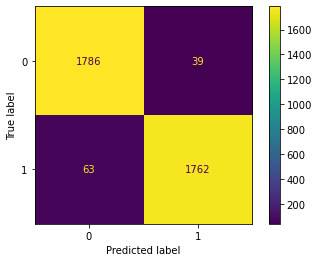

In [105]:
## SMOTE
###Random forest opimizing for precision (conservative estimate) with SMOTE data
rfc_params = [{'n_estimators': list(range(60,140,20)),
               'criterion': ['gini', 'entropy'], 
               'min_samples_split': list(range(1,4)), 
               'max_features': ['sqrt', 'log2'],
               'bootstrap': [True, False],
               'warm_start': [True, False]}]
rfc_grid = GridSearchCV(RandomForestClassifier(), rfc_params, cv = 10, scoring='f1')

rfc_grid.fit(X_res, y_res)

print(rfc_grid.best_params_)

print(rfc_grid.best_score_)

SMOTE_Random_Forest_f1_Scores = cross_val_score(rfc_grid.best_estimator_, X_res, y_res, cv=10)

y_train_pred = cross_val_predict(rfc_grid.best_estimator_, X_res, y_res, cv=10)
cm = confusion_matrix(y_res, y_train_pred)
print(cm)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rfc_grid.classes_)
cm_disp.plot()
plt.show()

SMOTE_Random_Forest_f1_file = 'SMOTE_Random_Forest_f1.sav'
pickle.dump(rfc_grid.best_estimator_, open(SMOTE_Random_Forest_f1_file, 'wb'))

C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
640 fits failed out of a total of 1920.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
640 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\

{'bootstrap': False, 'criterion': 'gini', 'max_features': 'log2', 'min_samples_split': 3, 'n_estimators': 120, 'warm_start': False}
0.9823007891856049
[[1787   38]
 [  66 1759]]


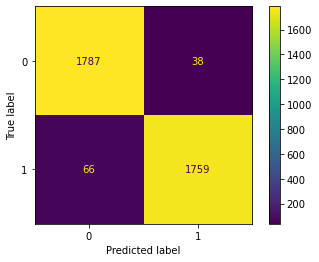

In [106]:
## SMOTE
###Random forest opimizing for precision (conservative estimate) with SMOTE data
rfc_params = [{'n_estimators': list(range(60,140,20)),
               'criterion': ['gini', 'entropy'], 
               'min_samples_split': list(range(1,4)), 
               'max_features': ['sqrt', 'log2'],
               'bootstrap': [True, False],
               'warm_start': [True, False]}]
rfc_grid = GridSearchCV(RandomForestClassifier(), rfc_params, cv = 10, scoring='precision')

rfc_grid.fit(X_res, y_res)

print(rfc_grid.best_params_)

print(rfc_grid.best_score_)

SMOTE_Random_Forest_precision_Scores = cross_val_score(rfc_grid.best_estimator_, X_res, y_res, cv=10)

y_train_pred = cross_val_predict(rfc_grid.best_estimator_, X_res, y_res, cv=10)
cm = confusion_matrix(y_res, y_train_pred)
print(cm)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rfc_grid.classes_)
cm_disp.plot()
plt.show()

SMOTE_Random_Forest_precision_file = 'SMOTE_Random_Forest_precision.sav'
pickle.dump(rfc_grid.best_estimator_, open(SMOTE_Random_Forest_precision_file, 'wb'))

In [107]:
## SMOTE Test Data
y_test_pred = cross_val_predict(rfc_grid.best_estimator_, X_test, y_test, cv=10)
cm = confusion_matrix(y_test, y_test_pred)
print(cm)


[[776   3]
 [ 45  24]]


C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
320 fits failed out of a total of 960.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
320 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\U

{'bootstrap': True, 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_split': 3, 'n_estimators': 100, 'warm_start': False}
0.9665753424657535
[[1785   40]
 [  64 1761]]


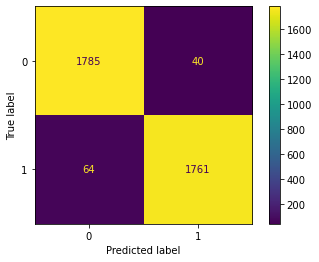

[[778   1]
 [ 52  17]]


In [108]:
## SMOTE
###Random forest opimizing for precision (conservative estimate) with SMOTE data
rfc_recall_params = [{'n_estimators': list(range(60,140,20)),
               'criterion': ['gini', 'entropy'], 
               'min_samples_split': list(range(1,4)), 
               'max_features': ['sqrt', 'log2'],
               'bootstrap': [True, False],
               'warm_start': [True, False]}]
rfc_recall_grid = GridSearchCV(RandomForestClassifier(), rfc_recall_params, cv = 5, scoring='recall')

rfc_recall_grid.fit(X_res, y_res)

print(rfc_recall_grid.best_params_)

print(rfc_recall_grid.best_score_)

SMOTE_Random_Forest_recall_Scores = cross_val_score(rfc_recall_grid.best_estimator_, X_res, y_res, cv=10)

y_train_pred = cross_val_predict(rfc_recall_grid.best_estimator_, X_res, y_res, cv=10)
cm = confusion_matrix(y_res, y_train_pred)
print(cm)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rfc_recall_grid.classes_)
cm_disp.plot()
plt.show()

## SMOTE Test Data
y_test_pred = cross_val_predict(rfc_recall_grid.best_estimator_, X_test, y_test, cv=10)
cm = confusion_matrix(y_test, y_test_pred)
print(cm)

SMOTE_Random_Forest_recall_file = 'SMOTE_Random_Forest_recall.sav'
pickle.dump(rfc_recall_grid.best_estimator_, open(SMOTE_Random_Forest_recall_file, 'wb'))

In [109]:
## SMOTE
# Gradien Boosting with precision scoring
##GradientBoostingClassifier
gbc_precision_params = [{'loss': ['log_loss', 'exponential'],
               'learning_rate': list(np.arange(0.05,0.1,0.05)), 
               'n_estimators': list(range(50,200,50)), 
               'criterion': ['friedman_mse', 'squared_error'],
               'warm_start': [True, False],
               'ccp_alpha' : list(np.arange(0.0,0.1,0.05))}] ## look at past project to see range used for alpha
gbc_grid = GridSearchCV(GradientBoostingClassifier(), gbc_precision_params, cv = 10, scoring='f1')

gbc_grid.fit(X_res, y_res)

print(gbc_grid.best_params_)

print(gbc_grid.best_score_)

SMOTE_Gradient_Boosting_f1_Scores = cross_val_score(gbc_grid.best_estimator_, X_res, y_res, cv=10)

y_train_pred = cross_val_predict(gbc_grid.best_estimator_, X_res, y_res, cv=10)
cm = confusion_matrix(y_res, y_train_pred)
print(cm)

y_test_pred = cross_val_predict(gbc_grid.best_estimator_, X_test, y_test, cv=10)
cm = confusion_matrix(y_test, y_test_pred)
print(cm)

SMOTE_Gradient_Boosting_f1_file = 'SMOTE_Gradient_Boosting_f1.sav'
pickle.dump(gbc_grid.best_estimator_, open(SMOTE_Gradient_Boosting_f1_file, 'wb'))

{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'learning_rate': 0.05, 'loss': 'exponential', 'n_estimators': 150, 'warm_start': True}
0.9349285687842418
[[1742   83]
 [ 132 1693]]
[[771   8]
 [ 56  13]]


In [110]:
## SMOTE
# Gradien Boosting with precision scoring
##GradientBoostingClassifier
gbc_precision_params = [{'loss': ['log_loss', 'exponential'],
               'learning_rate': list(np.arange(0.05,0.1,0.05)), 
               'n_estimators': list(range(50,200,50)), 
               'criterion': ['friedman_mse', 'squared_error'],
               'warm_start': [True, False],
               'ccp_alpha' : list(np.arange(0.0,0.1,0.05))}] ## look at past project to see range used for alpha
gbc_precision_grid = GridSearchCV(GradientBoostingClassifier(), gbc_precision_params, cv = 10, scoring='precision')

gbc_precision_grid.fit(X_res, y_res)

print(gbc_precision_grid.best_params_)

print(gbc_precision_grid.best_score_)

SMOTE_Gradient_Boosting_precision_Scores = cross_val_score(gbc_precision_grid.best_estimator_, X_res, y_res, cv=10)

y_train_pred = cross_val_predict(gbc_precision_grid.best_estimator_, X_res, y_res, cv=10)
cm = confusion_matrix(y_res, y_train_pred)
print(cm)

y_test_pred = cross_val_predict(gbc_precision_grid.best_estimator_, X_test, y_test, cv=10)
cm = confusion_matrix(y_test, y_test_pred)
print(cm)

SMOTE_Gradient_Boosting_precision_file = 'SMOTE_Gradient_Boosting_precision.sav'
pickle.dump(gbc_precision_grid.best_estimator_, open(SMOTE_Gradient_Boosting_precision_file, 'wb'))

C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469

C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469

C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469

{'ccp_alpha': 0.0, 'criterion': 'squared_error', 'learning_rate': 0.05, 'loss': 'log_loss', 'n_estimators': 150, 'warm_start': True}
0.955310003622697
[[1744   81]
 [ 137 1688]]
[[769  10]
 [ 51  18]]


In [111]:
##SMOTE
# Gradien Boosting with recall scoring
##GradientBoostingClassifier
gbc_recall_params = [{'loss': ['log_loss', 'exponential'],
               'learning_rate': list(np.arange(0.05,0.1,0.05)), 
               'n_estimators': list(range(50,200,50)), 
               'criterion': ['friedman_mse', 'squared_error'],
               'warm_start': [True, False],
               'ccp_alpha' : list(np.arange(0.0,0.15,0.05))}] ## look at past project to see range used for alpha
gbc_recall_grid = GridSearchCV(GradientBoostingClassifier(), gbc_recall_params, cv = 10, scoring='recall')

gbc_recall_grid.fit(X_res, y_res)

print(gbc_recall_grid.best_params_)

print(gbc_recall_grid.best_score_)

SMOTE_Gradient_Boosting_recall_Scores = cross_val_score(gbc_recall_grid.best_estimator_, X_res, y_res, cv=10)

y_train_pred = cross_val_predict(gbc_recall_grid.best_estimator_, X_res, y_res, cv=10)
cm = confusion_matrix(y_res, y_train_pred)
print(cm)

y_test_pred = cross_val_predict(gbc_recall_grid.best_estimator_, X_test, y_test, cv=10)
cm = confusion_matrix(y_test, y_test_pred)
print(cm)

SMOTE_Gradient_Boosting_recall_file = 'SMOTE_Gradient_Boosting_recall.sav'
pickle.dump(gbc_recall_grid.best_estimator_, open(SMOTE_Gradient_Boosting_recall_file, 'wb'))

{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'learning_rate': 0.05, 'loss': 'exponential', 'n_estimators': 150, 'warm_start': True}
0.9275746111811685
[[1742   83]
 [ 132 1693]]
[[771   8]
 [ 56  13]]


In [112]:
##SMOTE
## using xgboost
xgb_params = [{'verbosity': [0],
               'booster': ['gbtree', 'dart'],
               'eta': list(np.arange(0.0001,1.0000,0.0001)),
               'gamma': [0, 0.25, 0.5, 1.0],
               'max_depth': [4, 6, 8],
               'max_delta_step': list(range(1,10)),
               'sampling_method': ['uniform', 'gradient_based'],
               'lambda': [0.1, 1.0, 5.0, 10.0, 50.0, 100.0],
               'alpha': [0, 0.25, 0.5]}] 
xgb_grid = RandomizedSearchCV(xgb.XGBClassifier(), xgb_params, n_iter = 400, n_jobs = 5, cv = 10, scoring='f1')

xgb_grid.fit(X_res, y_res)

print(xgb_grid.best_params_)

print(xgb_grid.best_score_)

SMOTE_XGBoost_f1_Scores = cross_val_score(xgb_grid.best_estimator_, X_res, y_res, cv=10)

y_train_pred = cross_val_predict(xgb_grid.best_estimator_, X_res, y_res, cv=10)
cm = confusion_matrix(y_res, y_train_pred)
print(cm)

y_test_pred = cross_val_predict(xgb_grid.best_estimator_, X_test, y_test, cv=10)
cm = confusion_matrix(y_test, y_test_pred)
print(cm)

SMOTE_XGBoost_f1_file = 'SMOTE_XGBoost_f1.sav'
pickle.dump(xgb_grid.best_estimator_, open(SMOTE_XGBoost_f1_file, 'wb'))

{'verbosity': 0, 'sampling_method': 'gradient_based', 'max_depth': 8, 'max_delta_step': 5, 'lambda': 5.0, 'gamma': 0, 'eta': 0.6895, 'booster': 'gbtree', 'alpha': 0}
0.9608570466191135
[[1781   44]
 [  78 1747]]
[[765  14]
 [ 42  27]]


In [113]:
##SMOTE
## using xgboost
xgb_params = [{'verbosity': [0],
               'booster': ['gbtree', 'dart'],
               'eta': list(np.arange(0.0001,1.0000,0.0001)),
               'gamma': [0, 0.25, 0.5, 1.0],
               'max_depth': [4, 6, 8],
               'max_delta_step': list(range(1,10)),
               'sampling_method': ['uniform', 'gradient_based'],
               'lambda': [0.1, 1.0, 5.0, 10.0, 50.0, 100.0],
               'alpha': [0, 0.25, 0.5]}] 
xgb_grid_precision = RandomizedSearchCV(xgb.XGBClassifier(), xgb_params, n_iter = 400, n_jobs = 5, cv = 10, scoring='precision')

xgb_grid_precision.fit(X_res, y_res)

print(xgb_grid_precision.best_params_)

print(xgb_grid_precision.best_score_)

SMOTE_XGBoost_precision_Scores = cross_val_score(xgb_grid_precision.best_estimator_, X_res, y_res, cv=10)

y_train_pred = cross_val_predict(xgb_grid_precision.best_estimator_, X_res, y_res, cv=10)
cm = confusion_matrix(y_res, y_train_pred)
print(cm)

y_test_pred = cross_val_predict(xgb_grid_precision.best_estimator_, X_test, y_test, cv=10)
cm = confusion_matrix(y_test, y_test_pred)
print(cm)

SMOTE_XGBoost_precision_file = 'SMOTE_XGBoost_precision.sav'
pickle.dump(xgb_grid_precision.best_estimator_, open(SMOTE_XGBoost_precision_file, 'wb'))

{'verbosity': 0, 'sampling_method': 'gradient_based', 'max_depth': 8, 'max_delta_step': 2, 'lambda': 0.1, 'gamma': 0.25, 'eta': 0.1207, 'booster': 'gbtree', 'alpha': 0.25}
0.9792806987716031
[[1786   39]
 [  79 1746]]
[[765  14]
 [ 43  26]]


In [114]:
##SMOTE
## using xgboost
xgb_params = [{'verbosity': [0],
               'booster': ['gbtree', 'dart'],
               'eta': list(np.arange(0.0001,1.0000,0.0001)),
               'gamma': [0, 0.25, 0.5, 1.0],
               'max_depth': [4, 6, 8],
               'max_delta_step': list(range(1,10)),
               'sampling_method': ['uniform', 'gradient_based'],
               'lambda': [0.1, 1.0, 5.0, 10.0, 50.0, 100.0],
               'alpha': [0, 0.25, 0.5]}] 
xgb_grid_recall = RandomizedSearchCV(xgb.XGBClassifier(), xgb_params, n_iter = 400, n_jobs = 5, cv = 10, scoring='recall')

xgb_grid_recall.fit(X_res, y_res)

print(xgb_grid_recall.best_params_)

print(xgb_grid_recall.best_score_)

SMOTE_XGBoost_recall_Scores = cross_val_score(xgb_grid_recall.best_estimator_, X_res, y_res, cv=10)

y_train_pred = cross_val_predict(xgb_grid_recall.best_estimator_, X_res, y_res, cv=10)
cm = confusion_matrix(y_res, y_train_pred)
print(cm)

y_test_pred = cross_val_predict(xgb_grid_recall.best_estimator_, X_test, y_test, cv=10)
cm = confusion_matrix(y_test, y_test_pred)
print(cm)

SMOTE_XGBoost_recall_file = 'SMOTE_XGBoost_recall.sav'
pickle.dump(xgb_grid_recall.best_estimator_, open(SMOTE_XGBoost_recall_file, 'wb'))

{'verbosity': 0, 'sampling_method': 'gradient_based', 'max_depth': 8, 'max_delta_step': 3, 'lambda': 0.1, 'gamma': 1.0, 'eta': 0.8350000000000001, 'booster': 'dart', 'alpha': 0}
0.9571488620668948
[[1765   60]
 [  78 1747]]
[[762  17]
 [ 42  27]]


In [115]:
##SMOTE
# Decision Tree
## look in book for how to create map visual
dt_params = [{'criterion': ['gini', 'entropy'], 
               'min_samples_split': list(range(1,4)), 
               'max_features': ['sqrt', 'log2'],
               'splitter': ['best', 'random'],
               'ccp_alpha': [True, False]}] ## look at past project to see range used for alpha
dt_grid = GridSearchCV(DecisionTreeClassifier(), dt_params, cv = 10, scoring='f1')

dt_grid.fit(X_res, y_res)

print(dt_grid.best_params_)

print(dt_grid.best_score_)

SMOTE_Decision_Tree_f1_Scores = cross_val_score(dt_grid.best_estimator_, X_res, y_res, cv=10)

y_train_pred = cross_val_predict(dt_grid.best_estimator_, X_res, y_res, cv=10)
cm = confusion_matrix(y_res, y_train_pred)
print(cm)

y_test_pred = cross_val_predict(dt_grid.best_estimator_, X_test, y_test, cv=10)
cm = confusion_matrix(y_test, y_test_pred)
print(cm)

SMOTE_Decision_Tree_f1_file = 'SMOTE_Decision_Tree_f1.sav'
pickle.dump(dt_grid.best_estimator_, open(SMOTE_Decision_Tree_f1_file, 'wb'))

C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
160 fits failed out of a total of 480.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
160 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\U

{'ccp_alpha': False, 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_split': 2, 'splitter': 'random'}
0.9578539461008754
[[1725  100]
 [  80 1745]]
[[737  42]
 [ 42  27]]


In [116]:
##SMOTE
# Decision Tree
## look in book for how to create map visual
dt_params = [{'criterion': ['gini', 'entropy'], 
               'min_samples_split': list(range(1,4)), 
               'max_features': ['sqrt', 'log2'],
               'splitter': ['best', 'random'],
               'ccp_alpha': [True, False]}] ## look at past project to see range used for alpha
dt_grid_precision = GridSearchCV(DecisionTreeClassifier(), dt_params, cv = 10, scoring='precision')

dt_grid_precision.fit(X_res, y_res)

print(dt_grid_precision.best_params_)

print(dt_grid_precision.best_score_)

SMOTE_Decision_Tree_precision_Scores = cross_val_score(dt_grid_precision.best_estimator_, X_res, y_res, cv=10)

y_train_pred = cross_val_predict(dt_grid_precision.best_estimator_, X_res, y_res, cv=10)
cm = confusion_matrix(y_res, y_train_pred)
print(cm)

y_test_pred = cross_val_predict(dt_grid_precision.best_estimator_, X_test, y_test, cv=10)
cm = confusion_matrix(y_test, y_test_pred)
print(cm)

SMOTE_Decision_Tree_precision_file = 'SMOTE_Decision_Tree_precision.sav'
pickle.dump(dt_grid_precision.best_estimator_, open(SMOTE_Decision_Tree_precision_file, 'wb'))

C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469

C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469

C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469

{'ccp_alpha': False, 'criterion': 'gini', 'max_features': 'log2', 'min_samples_split': 3, 'splitter': 'random'}
0.9682382478498329
[[1752   73]
 [  85 1740]]
[[757  22]
 [ 50  19]]


In [117]:
##SMOTE
# Decision Tree
## look in book for how to create map visual
dt_params = [{'criterion': ['gini', 'entropy'], 
               'min_samples_split': list(range(1,4)), 
               'max_features': ['sqrt', 'log2'],
               'splitter': ['best', 'random'],
               'ccp_alpha': [True, False]}] ## look at past project to see range used for alpha
dt_grid_recall = GridSearchCV(DecisionTreeClassifier(), dt_params, cv = 10, scoring='recall')

dt_grid_recall.fit(X_res, y_res)

print(dt_grid_recall.best_params_)

print(dt_grid_recall.best_score_)

SMOTE_Decision_Tree_recall_Scores = cross_val_score(dt_grid_recall.best_estimator_, X_res, y_res, cv=10)

y_train_pred = cross_val_predict(dt_grid_recall.best_estimator_, X_res, y_res, cv=10)
cm = confusion_matrix(y_res, y_train_pred)
print(cm)

y_test_pred = cross_val_predict(dt_grid_recall.best_estimator_, X_test, y_test, cv=10)
cm = confusion_matrix(y_test, y_test_pred)
print(cm)

SMOTE_Decision_Tree_recall_file = 'SMOTE_Decision_Tree_recall.sav'
pickle.dump(dt_grid_recall.best_estimator_, open(SMOTE_Decision_Tree_recall_file, 'wb'))

{'ccp_alpha': False, 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_split': 2, 'splitter': 'random'}
0.9659821053263675
[[1753   72]
 [  77 1748]]
[[745  34]
 [ 45  24]]


C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
160 fits failed out of a total of 480.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
160 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\U

In [118]:
Random_Forest_f1 = pickle.load(open('Random_Forest_f1.sav', 'rb'))
Random_Forest_precision = pickle.load(open('Random_Forest_precision.sav', 'rb'))
Random_Forest_recall = pickle.load(open('Random_Forest_recall.sav', 'rb'))
Gradient_Boosting_f1 = pickle.load(open('Gradient_Boosting_f1.sav', 'rb'))
Gradient_Boosting_precision = pickle.load(open('Gradient_Boosting_precision.sav', 'rb'))
Gradient_Boosting_recall = pickle.load(open('Gradient_Boosting_recall.sav', 'rb'))
Decision_Tree_f1 = pickle.load(open('Decision_Tree_f1.sav', 'rb'))
Decision_Tree_precision = pickle.load(open('Decision_Tree_precision.sav', 'rb'))
Decision_Tree_recall = pickle.load(open('Decision_Tree_recall.sav', 'rb'))
XGBoost_f1 = pickle.load(open('XGBoost_f1.sav', 'rb'))
XGBoost_precision = pickle.load(open('XGBoost_precision.sav', 'rb'))
XGBoost_recall = pickle.load(open('XGBoost_recall.sav', 'rb'))

SMOTE_Random_Forest_f1 = pickle.load(open('SMOTE_Random_Forest_f1.sav', 'rb'))
SMOTE_Random_Forest_precision = pickle.load(open('SMOTE_Random_Forest_precision.sav', 'rb'))
SMOTE_Random_Forest_recall = pickle.load(open('SMOTE_Random_Forest_recall.sav', 'rb'))
SMOTE_Gradient_Boosting_f1 = pickle.load(open('SMOTE_Gradient_Boosting_f1.sav', 'rb'))
SMOTE_Gradient_Boosting_precision = pickle.load(open('SMOTE_Gradient_Boosting_precision.sav', 'rb'))
SMOTE_Gradient_Boosting_recall = pickle.load(open('SMOTE_Gradient_Boosting_recall.sav', 'rb'))
SMOTE_Decision_Tree_f1 = pickle.load(open('SMOTE_Decision_Tree_f1.sav', 'rb'))
SMOTE_Decision_Tree_precision = pickle.load(open('SMOTE_Decision_Tree_precision.sav', 'rb'))
SMOTE_Decision_Tree_recall = pickle.load(open('SMOTE_Decision_Tree_recall.sav', 'rb'))
SMOTE_XGBoost_f1 = pickle.load(open('SMOTE_XGBoost_f1.sav', 'rb'))
SMOTE_XGBoost_precision = pickle.load(open('SMOTE_XGBoost_precision.sav', 'rb'))
SMOTE_XGBoost_recall = pickle.load(open('SMOTE_XGBoost_recall.sav', 'rb'))

In [119]:
### CV Scores on Training data
Random_Forest_f1_train_Scores = cross_val_score(Random_Forest_f1, X_train, y_train, cv=10, scoring='f1')
Random_Forest_precision_train_Scores = cross_val_score(Random_Forest_precision, X_train, y_train, cv=10, scoring='precision')
Random_Forest_recall_train_Scores = cross_val_score(Random_Forest_recall, X_train, y_train, cv=10, scoring='recall')
Gradient_Boosting_f1_train_Scores = cross_val_score(Gradient_Boosting_f1, X_train, y_train, cv=10, scoring='f1')
Gradient_Boosting_precision_train_Scores = cross_val_score(Gradient_Boosting_precision, X_train, y_train, cv=10, scoring='precision')
Gradient_Boosting_recall_train_Scores = cross_val_score(Gradient_Boosting_recall, X_train, y_train, cv=10, scoring='recall')
Decision_Tree_f1_train_Scores = cross_val_score(Decision_Tree_f1, X_train, y_train, cv=10, scoring='f1')
Decision_Tree_precision_train_Scores = cross_val_score(Decision_Tree_precision, X_train, y_train, cv=10, scoring='precision')
Decision_Tree_recall_train_Scores = cross_val_score(Decision_Tree_recall, X_train, y_train, cv=10, scoring='recall')
XGBoost_f1_train_Scores = cross_val_score(XGBoost_f1, X_train, y_train, cv=10, scoring='f1')
XGBoost_precision_train_Scores = cross_val_score(XGBoost_precision, X_train, y_train, cv=10, scoring='precision')
XGBoost_recall_train_Scores = cross_val_score(XGBoost_recall, X_train, y_train, cv=10, scoring='recall')

SMOTE_Random_Forest_f1_train_Scores = cross_val_score(SMOTE_Random_Forest_f1, X_res, y_res, cv=10, scoring='f1')
SMOTE_Random_Forest_precision_train_Scores = cross_val_score(SMOTE_Random_Forest_precision, X_res, y_res, cv=10, scoring='precision')
SMOTE_Random_Forest_recall_train_Scores = cross_val_score(SMOTE_Random_Forest_recall, X_res, y_res, cv=10, scoring='recall')
SMOTE_Gradient_Boosting_f1_train_Scores = cross_val_score(SMOTE_Gradient_Boosting_f1, X_res, y_res, cv=10, scoring='f1')
SMOTE_Gradient_Boosting_precision_train_Scores = cross_val_score(SMOTE_Gradient_Boosting_precision, X_res, y_res, cv=10, scoring='precision')
SMOTE_Gradient_Boosting_recall_train_Scores = cross_val_score(SMOTE_Gradient_Boosting_recall, X_res, y_res, cv=10, scoring='recall')
SMOTE_Decision_Tree_f1_train_Scores = cross_val_score(SMOTE_Decision_Tree_f1, X_res, y_res, cv=10, scoring='f1')
SMOTE_Decision_Tree_precision_train_Scores = cross_val_score(SMOTE_Decision_Tree_precision, X_res, y_res, cv=10, scoring='precision')
SMOTE_Decision_Tree_recall_train_Scores = cross_val_score(SMOTE_Decision_Tree_recall, X_res, y_res, cv=10, scoring='recall')
SMOTE_XGBoost_f1_train_Scores = cross_val_score(SMOTE_XGBoost_f1, X_res, y_res, cv=10, scoring='f1')
SMOTE_XGBoost_precision_train_Scores = cross_val_score(SMOTE_XGBoost_precision, X_res, y_res, cv=10, scoring='precision')
SMOTE_XGBoost_recall_train_Scores = cross_val_score(SMOTE_XGBoost_recall, X_res, y_res, cv=10, scoring='recall')

In [120]:
### CV Scores on Test data
Random_Forest_f1_test_Scores = cross_val_score(Random_Forest_f1, X_test, y_test, cv=10, scoring='f1')
Random_Forest_precision_test_Scores = cross_val_score(Random_Forest_precision, X_test, y_test, cv=10, scoring='precision')
Random_Forest_recall_test_Scores = cross_val_score(Random_Forest_recall, X_test, y_test, cv=10, scoring='recall')
Gradient_Boosting_f1_test_Scores = cross_val_score(Gradient_Boosting_f1, X_test, y_test, cv=10, scoring='f1')
Gradient_Boosting_precision_test_Scores = cross_val_score(Gradient_Boosting_precision, X_test, y_test, cv=10, scoring='precision')
Gradient_Boosting_recall_test_Scores = cross_val_score(Gradient_Boosting_recall, X_test, y_test, cv=10, scoring='recall')
Decision_Tree_f1_test_Scores = cross_val_score(Decision_Tree_f1, X_test, y_test, cv=10, scoring='f1')
Decision_Tree_precision_test_Scores = cross_val_score(Decision_Tree_precision, X_test, y_test, cv=10, scoring='precision')
Decision_Tree_recall_test_Scores = cross_val_score(Decision_Tree_recall, X_test, y_test, cv=10, scoring='recall')
XGBoost_f1_test_Scores = cross_val_score(XGBoost_f1, X_test, y_test, cv=10, scoring='f1')
XGBoost_precision_test_Scores = cross_val_score(XGBoost_precision, X_test, y_test, cv=10, scoring='precision')
XGBoost_recall_test_Scores = cross_val_score(XGBoost_recall, X_test, y_test, cv=10, scoring='recall')

SMOTE_Random_Forest_f1_test_Scores = cross_val_score(SMOTE_Random_Forest_f1, X_test, y_test, cv=10, scoring='f1')
SMOTE_Random_Forest_precision_test_Scores = cross_val_score(SMOTE_Random_Forest_precision, X_test, y_test, cv=10, scoring='precision')
SMOTE_Random_Forest_recall_test_Scores = cross_val_score(SMOTE_Random_Forest_recall, X_test, y_test, cv=10, scoring='recall')
SMOTE_Gradient_Boosting_f1_test_Scores = cross_val_score(SMOTE_Gradient_Boosting_f1, X_test, y_test, cv=10, scoring='f1')
SMOTE_Gradient_Boosting_precision_test_Scores = cross_val_score(SMOTE_Gradient_Boosting_precision, X_test, y_test, cv=10, scoring='precision')
SMOTE_Gradient_Boosting_recall_test_Scores = cross_val_score(SMOTE_Gradient_Boosting_recall, X_test, y_test, cv=10, scoring='recall')
SMOTE_Decision_Tree_f1_test_Scores = cross_val_score(SMOTE_Decision_Tree_f1, X_test, y_test, cv=10, scoring='f1')
SMOTE_Decision_Tree_precision_test_Scores = cross_val_score(SMOTE_Decision_Tree_precision, X_test, y_test, cv=10, scoring='precision')
SMOTE_Decision_Tree_recall_test_Scores = cross_val_score(SMOTE_Decision_Tree_recall, X_test, y_test, cv=10, scoring='recall')
SMOTE_XGBoost_f1_test_Scores = cross_val_score(SMOTE_XGBoost_f1, X_test, y_test, cv=10, scoring='f1')
SMOTE_XGBoost_precision_test_Scores = cross_val_score(SMOTE_XGBoost_precision, X_test, y_test, cv=10, scoring='precision')
SMOTE_XGBoost_recall_test_Scores = cross_val_score(SMOTE_XGBoost_recall, X_test, y_test, cv=10, scoring='recall')

C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nbrow\Downloads\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469

In [121]:
#### Training Scores
Training_precision_arrays = [Random_Forest_precision_train_Scores,
                    SMOTE_Random_Forest_precision_train_Scores,
                    Gradient_Boosting_precision_train_Scores,
                    SMOTE_Gradient_Boosting_precision_train_Scores,
                    XGBoost_precision_train_Scores,
                    SMOTE_XGBoost_precision_train_Scores,
                    Decision_Tree_precision_train_Scores,
                    SMOTE_Decision_Tree_precision_train_Scores]
#print(sns.boxplot(data=Training_precision_arrays))

Training_f1_arrays = [Random_Forest_f1_train_Scores,
             SMOTE_Random_Forest_f1_train_Scores,
             Gradient_Boosting_f1_train_Scores,
             SMOTE_Gradient_Boosting_f1_train_Scores,
             XGBoost_f1_train_Scores,
             SMOTE_XGBoost_f1_train_Scores,
             Decision_Tree_f1_train_Scores,
             SMOTE_Decision_Tree_f1_train_Scores]
#print(sns.boxplot(data=Training_f1_arrays))

Training_recall_arrays = [Random_Forest_recall_train_Scores,
                 SMOTE_Random_Forest_recall_train_Scores,
                 Gradient_Boosting_recall_train_Scores,
                 SMOTE_Gradient_Boosting_recall_train_Scores,
                 XGBoost_recall_train_Scores,
                 SMOTE_XGBoost_recall_train_Scores,
                 Decision_Tree_recall_train_Scores,
                 SMOTE_Decision_Tree_recall_train_Scores]
#sns.boxplot(data=Training_recall_arrays)


In [122]:
#### Test Scores
Test_precision_arrays = [Random_Forest_precision_test_Scores,
                    SMOTE_Random_Forest_precision_test_Scores,
                    Gradient_Boosting_precision_test_Scores,
                    SMOTE_Gradient_Boosting_precision_test_Scores,
                    XGBoost_precision_test_Scores,
                    SMOTE_XGBoost_precision_test_Scores,
                    Decision_Tree_precision_test_Scores,
                    SMOTE_Decision_Tree_precision_test_Scores]


Test_f1_arrays = [Random_Forest_f1_test_Scores,
             SMOTE_Random_Forest_f1_test_Scores,
             Gradient_Boosting_f1_test_Scores,
             SMOTE_Gradient_Boosting_f1_test_Scores,
             XGBoost_f1_test_Scores,
             SMOTE_XGBoost_f1_test_Scores,
             Decision_Tree_f1_test_Scores,
             SMOTE_Decision_Tree_f1_test_Scores]


Test_recall_arrays = [Random_Forest_recall_test_Scores,
                 SMOTE_Random_Forest_recall_test_Scores,
                 Gradient_Boosting_recall_test_Scores,
                 SMOTE_Gradient_Boosting_recall_test_Scores,
                 XGBoost_recall_test_Scores,
                 SMOTE_XGBoost_recall_test_Scores,
                 Decision_Tree_recall_test_Scores,
                 SMOTE_Decision_Tree_recall_test_Scores]


AxesSubplot(0.125,0.125;0.775x0.755)


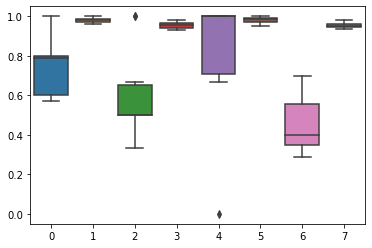

In [123]:
## Traning Precision plot
print(sns.boxplot(data=Training_precision_arrays))

AxesSubplot(0.125,0.125;0.775x0.755)


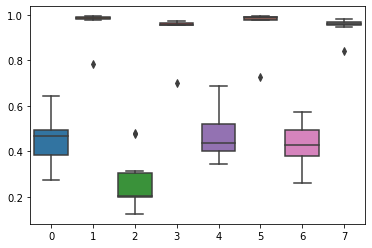

In [124]:
## Training F1 plot
print(sns.boxplot(data=Training_f1_arrays))

<AxesSubplot:>

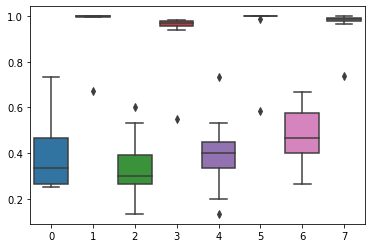

In [125]:
## Training recall plot
sns.boxplot(data=Training_recall_arrays)

AxesSubplot(0.125,0.125;0.775x0.755)


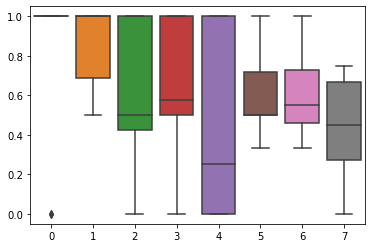

In [126]:
## Test Precision plot
print(sns.boxplot(data=Test_precision_arrays))

AxesSubplot(0.125,0.125;0.775x0.755)


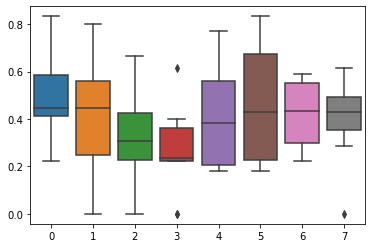

In [127]:
## Test F1 plot
print(sns.boxplot(data=Test_f1_arrays))

<AxesSubplot:>

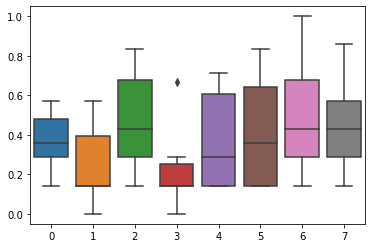

In [128]:
## Test recall plot
sns.boxplot(data=Test_recall_arrays)

In [129]:
### Create Dictionary of Score values for traniing data metrics
Training_precision_dict = {"Random_Forest_precision_train" : Random_Forest_precision_train_Scores,
                    "SMOTE_Random_Forest_precision_train" : SMOTE_Random_Forest_precision_train_Scores,
                    "Gradient_Boosting_precision_train" : Gradient_Boosting_precision_train_Scores,
                    "SMOTE_Gradient_Boosting_precision_train" : SMOTE_Gradient_Boosting_precision_train_Scores,
                    "XGBoost_precision_train" : XGBoost_precision_train_Scores,
                    "SMOTE_XGBoost_precision_train" : SMOTE_XGBoost_precision_train_Scores,
                    "Decision_Tree_precision_train" : Decision_Tree_precision_train_Scores,
                    "SMOTE_Decision_Tree_precision_train" : SMOTE_Decision_Tree_precision_train_Scores}

Training_f1_dict = {"Random_Forest_f1_train" : Random_Forest_f1_train_Scores,
             "SMOTE_Random_Forest_f1_train" : SMOTE_Random_Forest_f1_train_Scores,
             "Gradient_Boosting_f1_train" : Gradient_Boosting_f1_train_Scores,
             "SMOTE_Gradient_Boosting_f1_train" : SMOTE_Gradient_Boosting_f1_train_Scores,
             "XGBoost_f1_train" : XGBoost_f1_train_Scores,
             "SMOTE_XGBoost_f1_train" : SMOTE_XGBoost_f1_train_Scores,
             "Decision_Tree_f1_train" : Decision_Tree_f1_train_Scores,
             "SMOTE_Decision_Tree_f1_train" : SMOTE_Decision_Tree_f1_train_Scores}

Training_recall_dict = {"Random_Forest_recall_train" : Random_Forest_recall_train_Scores,
                 "SMOTE_Random_Forest_recall_train" : SMOTE_Random_Forest_recall_train_Scores,
                 "Gradient_Boosting_recall_train" : Gradient_Boosting_recall_train_Scores,
                 "SMOTE_Gradient_Boosting_recall_train" : SMOTE_Gradient_Boosting_recall_train_Scores,
                 "XGBoost_recall_train" : XGBoost_recall_train_Scores,
                 "SMOTE_XGBoost_recall_train" : SMOTE_XGBoost_recall_train_Scores,
                 "Decision_Tree_recall_train" : Decision_Tree_recall_train_Scores,
                 "SMOTE_Decision_Tree_recall_train" : SMOTE_Decision_Tree_recall_train_Scores}

### Create Dictionary of Score values for test data metrics
Test_precision_dict = {"Random_Forest_precision_test" : Random_Forest_precision_test_Scores,
                    "SMOTE_Random_Forest_precision_test" : SMOTE_Random_Forest_precision_test_Scores,
                    "Gradient_Boosting_precision_test" : Gradient_Boosting_precision_test_Scores,
                    "SMOTE_Gradient_Boosting_precision_test" : SMOTE_Gradient_Boosting_precision_test_Scores,
                    "XGBoost_precision_test" : XGBoost_precision_test_Scores,
                    "SMOTE_XGBoost_precision_test" : SMOTE_XGBoost_precision_test_Scores,
                    "Decision_Tree_precision_test" : Decision_Tree_precision_test_Scores,
                    "SMOTE_Decision_Tree_precision_test" : SMOTE_Decision_Tree_precision_test_Scores}

Test_f1_dict = {"Random_Forest_f1_test" : Random_Forest_f1_test_Scores,
             "SMOTE_Random_Forest_f1_test" : SMOTE_Random_Forest_f1_test_Scores,
             "Gradient_Boosting_f1_test" : Gradient_Boosting_f1_test_Scores,
             "SMOTE_Gradient_Boosting_f1_test" : SMOTE_Gradient_Boosting_f1_test_Scores,
             "XGBoost_f1_test" : XGBoost_f1_test_Scores,
             "SMOTE_XGBoost_f1_test" : SMOTE_XGBoost_f1_test_Scores,
             "Decision_Tree_f1_test" : Decision_Tree_f1_test_Scores,
             "SMOTE_Decision_Tree_f1_test" : SMOTE_Decision_Tree_f1_test_Scores}

Test_recall_dict = {"Random_Forest_recall_test" : Random_Forest_recall_test_Scores,
                 "SMOTE_Random_Forest_recall_test" : SMOTE_Random_Forest_recall_test_Scores,
                 "Gradient_Boosting_recall_test" : Gradient_Boosting_recall_test_Scores,
                 "SMOTE_Gradient_Boosting_recall_test" : SMOTE_Gradient_Boosting_recall_test_Scores,
                 "XGBoost_recall_test" : XGBoost_recall_test_Scores,
                 "SMOTE_XGBoost_recall_test" : SMOTE_XGBoost_recall_test_Scores,
                 "Decision_Tree_recall_test" : Decision_Tree_recall_test_Scores,
                 "SMOTE_Decision_Tree_recall_test" : SMOTE_Decision_Tree_recall_test_Scores}

In [130]:

##for i in Training_precision_dict:
f1_training_table = pd.DataFrame({'model':[], 'max':[], 'min':[], 'avg':[], 'std':[]})
precision_training_table = pd.DataFrame({'model':[], 'max':[], 'min':[], 'avg':[], 'std':[]})
recall_training_table = pd.DataFrame({'model':[], 'max':[], 'min':[], 'avg':[], 'std':[]})

## Populate df of f1 training scores
for key, value in Training_f1_dict.items():
    new_row = {'model':key, 'max':max(value), 'min':min(value), 'avg':np.mean(value), 'std':np.std(value)}
    f1_training_table = f1_training_table.append(new_row, ignore_index=True)
    
## Populate df of precision training scores
for key, value in Training_precision_dict.items():
    new_row = {'model':key, 'max':max(value), 'min':min(value), 'avg':np.mean(value), 'std':np.std(value)}
    precision_training_table = precision_training_table.append(new_row, ignore_index=True)
    
## Populate df of recall training scores
for key, value in Training_recall_dict.items():
    new_row = {'model':key, 'max':max(value), 'min':min(value), 'avg':np.mean(value), 'std':np.std(value)}
    recall_training_table = recall_training_table.append(new_row, ignore_index=True)

##for i in Testprecision_dict:
f1_test_table = pd.DataFrame({'model':[], 'max':[], 'min':[], 'avg':[], 'std':[]})
precision_test_table = pd.DataFrame({'model':[], 'max':[], 'min':[], 'avg':[], 'std':[]})
recall_test_table = pd.DataFrame({'model':[], 'max':[], 'min':[], 'avg':[], 'std':[]})

## Populate df of f1 training scores
for key, value in Test_f1_dict.items():
    new_row = {'model':key, 'max':max(value), 'min':min(value), 'avg':np.mean(value), 'std':np.std(value)}
    f1_test_table = f1_test_table.append(new_row, ignore_index=True)
    
## Populate df of precision training scores
for key, value in Test_precision_dict.items():
    new_row = {'model':key, 'max':max(value), 'min':min(value), 'avg':np.mean(value), 'std':np.std(value)}
    precision_test_table = precision_test_table.append(new_row, ignore_index=True)
    
## Populate df of recall training scores
for key, value in Test_recall_dict.items():
    new_row = {'model':key, 'max':max(value), 'min':min(value), 'avg':np.mean(value), 'std':np.std(value)}
    recall_test_table = recall_test_table.append(new_row, ignore_index=True)

In [131]:
f1_training_table

,model,max,min,avg,std
0,Random_Forest_f1_train,0.642857,0.272727,0.455522,0.098320
1,SMOTE_Random_Forest_f1_train,0.994565,0.786667,0.967305,0.060405
2,Gradient_Boosting_f1_train,0.480000,0.125000,0.267071,0.115853
3,SMOTE_Gradient_Boosting_f1_train,0.975207,0.699301,0.934929,0.078814
4,XGBoost_f1_train,0.687500,0.344828,0.473990,0.106868
5,SMOTE_XGBoost_f1_train,0.994565,0.727273,0.960857,0.078077
6,Decision_Tree_f1_train,0.571429,0.260870,0.432959,0.089153
7,SMOTE_Decision_Tree_f1_train,0.983607,0.842767,0.951821,0.037422


In [132]:
precision_training_table

,model,max,min,avg,std
0,Random_Forest_precision_train,1.000000,0.571429,0.738254,0.132561
1,SMOTE_Random_Forest_precision_train,1.000000,0.962963,0.979186,0.010685
2,Gradient_Boosting_precision_train,1.000000,0.333333,0.600000,0.218072
3,SMOTE_Gradient_Boosting_precision_train,0.983333,0.931217,0.955310,0.016994
4,XGBoost_precision_train,1.000000,0.000000,0.816667,0.302306
5,SMOTE_XGBoost_precision_train,1.000000,0.952880,0.979281,0.014891
6,Decision_Tree_precision_train,0.700000,0.285714,0.453366,0.132565
7,SMOTE_Decision_Tree_precision_train,0.979167,0.937173,0.954195,0.014250


In [133]:
recall_training_table

,model,max,min,avg,std
0,Random_Forest_recall_train,0.733333,0.250000,0.385000,0.143846
1,SMOTE_Random_Forest_recall_train,1.000000,0.670330,0.965937,0.098559
2,Gradient_Boosting_recall_train,0.600000,0.133333,0.344167,0.131870
3,SMOTE_Gradient_Boosting_recall_train,0.983607,0.549451,0.927575,0.126679
4,XGBoost_recall_train,0.733333,0.133333,0.397917,0.158763
5,SMOTE_XGBoost_recall_train,1.000000,0.582418,0.957149,0.124953
6,Decision_Tree_recall_train,0.666667,0.266667,0.470000,0.119675
7,SMOTE_Decision_Tree_recall_train,1.000000,0.736264,0.961040,0.075485


In [134]:
### Best Training F1 score
print(stats.ttest_ind(a=Random_Forest_f1_train_Scores, b=SMOTE_XGBoost_f1_train_Scores, equal_var=True))

### Best Training precision score
print(stats.ttest_ind(a=Random_Forest_precision_train_Scores, b=SMOTE_XGBoost_precision_train_Scores, equal_var=True))

### Best Training recall score
print(stats.ttest_ind(a=Random_Forest_recall_train_Scores, b=SMOTE_XGBoost_recall_train_Scores, equal_var=True))

Ttest_indResult(statistic=-12.074903684951812, pvalue=4.5651665576878883e-10)
Ttest_indResult(statistic=-5.420606610700011, pvalue=3.770496263256135e-05)
Ttest_indResult(statistic=-9.008400381536946, pvalue=4.343518636781393e-08)


In [135]:
f1_test_table

,model,max,min,avg,std
0,Random_Forest_f1_test,0.833333,0.222222,0.485101,0.175401
1,SMOTE_Random_Forest_f1_test,0.800000,0.000000,0.383333,0.246607
2,Gradient_Boosting_f1_test,0.666667,0.000000,0.338283,0.185971
3,SMOTE_Gradient_Boosting_f1_test,0.615385,0.000000,0.258205,0.174685
4,XGBoost_f1_test,0.769231,0.181818,0.406658,0.210139
5,SMOTE_XGBoost_f1_test,0.833333,0.181818,0.460011,0.233480
6,Decision_Tree_f1_test,0.588235,0.222222,0.423852,0.133438
7,SMOTE_Decision_Tree_f1_test,0.615385,0.000000,0.400536,0.163081


In [136]:
precision_test_table

,model,max,min,avg,std
0,Random_Forest_precision_test,1.00,0.000000,0.800000,0.400000
1,SMOTE_Random_Forest_precision_test,1.00,0.500000,0.851667,0.190679
2,Gradient_Boosting_precision_test,1.00,0.000000,0.590000,0.378021
3,SMOTE_Gradient_Boosting_precision_test,1.00,0.000000,0.665556,0.314484
4,XGBoost_precision_test,1.00,0.000000,0.450000,0.471699
5,SMOTE_XGBoost_precision_test,1.00,0.333333,0.587500,0.204507
6,Decision_Tree_precision_test,1.00,0.333333,0.612778,0.230593
7,SMOTE_Decision_Tree_precision_test,0.75,0.000000,0.451667,0.244432


In [137]:
recall_test_table

,model,max,min,avg,std
0,Random_Forest_recall_test,0.571429,0.142857,0.364286,0.151354
1,SMOTE_Random_Forest_recall_test,0.571429,0.000000,0.250000,0.178571
2,Gradient_Boosting_recall_test,0.833333,0.142857,0.454762,0.233394
3,SMOTE_Gradient_Boosting_recall_test,0.666667,0.000000,0.195238,0.181265
4,XGBoost_recall_test,0.714286,0.142857,0.366667,0.234303
5,SMOTE_XGBoost_recall_test,0.833333,0.142857,0.397619,0.257770
6,Decision_Tree_recall_test,1.000000,0.142857,0.483333,0.276857
7,SMOTE_Decision_Tree_recall_test,0.857143,0.142857,0.469048,0.226891


In [138]:
### Best Training F1 score
print(stats.ttest_ind(a=Decision_Tree_f1_test_Scores, b=Random_Forest_f1_test_Scores, equal_var=True))

### Best Training precision score
print(stats.ttest_ind(a=SMOTE_Random_Forest_precision_test_Scores, b=Random_Forest_precision_test_Scores, equal_var=True))
print(stats.ttest_ind(a=SMOTE_Random_Forest_precision_test_Scores, b=Gradient_Boosting_precision_test_Scores, equal_var=True))

### Best Training recall score
print(stats.ttest_ind(a=SMOTE_Decision_Tree_recall_test_Scores, b=XGBoost_recall_test_Scores, equal_var=True))

Ttest_indResult(statistic=-0.8337403595250843, pvalue=0.41535474262917504)
Ttest_indResult(statistic=0.34978971013884386, pvalue=0.7305558213362815)
Ttest_indResult(statistic=1.854086448372909, pvalue=0.08018727160846321)
Ttest_indResult(statistic=0.9417061917385657, pvalue=0.35881105295023286)


In [139]:
f1_importance = pd.DataFrame({'name':[], 'f1_score':[]})
for score, name in zip(Decision_Tree_f1.feature_importances_, X_test.columns):
    #print(round(score,2), name)
    score = round(score,4)
    new_row = {'name':name, 'f1_score':score}
    f1_importance = f1_importance.append(new_row, ignore_index=True)
#f1_importance.sort_values(by=['score'], ascending=False)

precision_importance = pd.DataFrame({'name':[], 'precision_score':[]})
for score, name in zip(SMOTE_Random_Forest_precision.feature_importances_, X_test.columns):
    #print(round(score,2), name)
    score = round(score,4)
    new_row = {'name':name, 'precision_score':score}
    precision_importance = precision_importance.append(new_row, ignore_index=True)
#precision_importance.sort_values(by=['score'], ascending=False)

recall_importance = pd.DataFrame({'name':[], 'recall_score':[]})
for score, name in zip(SMOTE_Decision_Tree_recall.feature_importances_, X_test.columns):
    #print(round(score,2), name)
    score = round(score,4)
    new_row = {'name':name, 'recall_score':score}
    recall_importance = recall_importance.append(new_row, ignore_index=True)
#recall_importance.sort_values(by=['score'], ascending=False)

all_scores = pd.concat([f1_importance, precision_importance['precision_score'], recall_importance['recall_score']], axis=1)
all_scores['avg_score'] = (all_scores['f1_score'] + all_scores['precision_score'] + all_scores['recall_score'])/3
all_scores.sort_values(by=['avg_score'], ascending=False).head(5)

,name,f1_score,precision_score,recall_score,avg_score
5,Days_Since_Last_Activity,0.1481,0.1184,0.0670,0.111167
2,Number_of_Days_in_Stage,0.1028,0.1004,0.1244,0.109200
1,Booking_Amount_Annualized,0.1396,0.0857,0.0556,0.093633
0,Booking_Amount,0.1320,0.0793,0.0653,0.092200
3,Push_Count,0.0904,0.0659,0.0948,0.083700


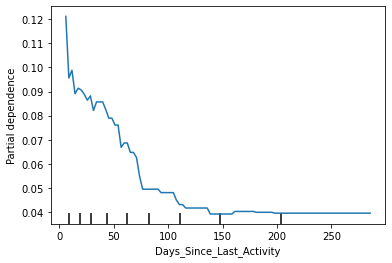

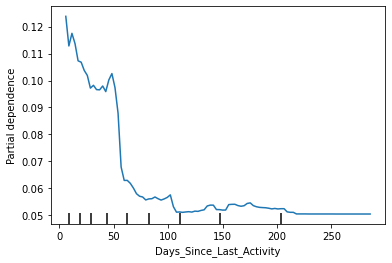

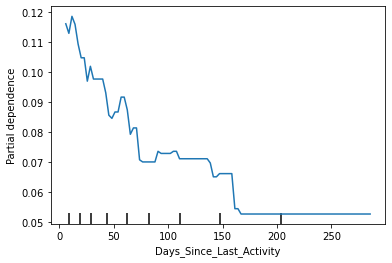

In [150]:
#Partial Dependancy for days since last activity
PartialDependenceDisplay.from_estimator(Decision_Tree_f1, X, ['Days_Since_Last_Activity'])
PartialDependenceDisplay.from_estimator(SMOTE_Random_Forest_precision, X, ['Days_Since_Last_Activity'])
PartialDependenceDisplay.from_estimator(SMOTE_Decision_Tree_recall, X, ['Days_Since_Last_Activity'])

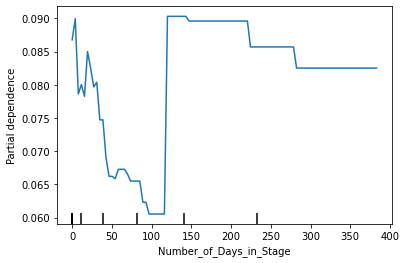

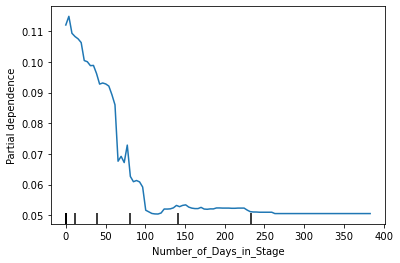

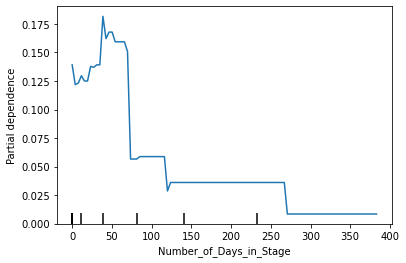

In [149]:
#Partial Dependancy for days in stage
PartialDependenceDisplay.from_estimator(Decision_Tree_f1, X, ['Number_of_Days_in_Stage'])
PartialDependenceDisplay.from_estimator(SMOTE_Random_Forest_precision, X, ['Number_of_Days_in_Stage'])
PartialDependenceDisplay.from_estimator(SMOTE_Decision_Tree_recall, X, ['Number_of_Days_in_Stage'])

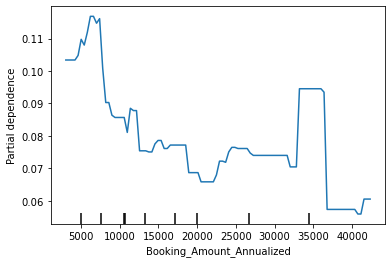

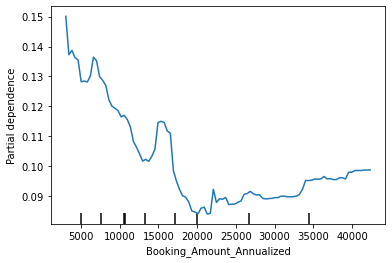

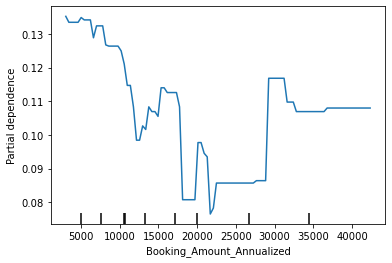

In [151]:
#Partial Dependancy for Booking amount annualized
PartialDependenceDisplay.from_estimator(Decision_Tree_f1, X, ['Booking_Amount_Annualized'])
PartialDependenceDisplay.from_estimator(SMOTE_Random_Forest_precision, X, ['Booking_Amount_Annualized'])
PartialDependenceDisplay.from_estimator(SMOTE_Decision_Tree_recall, X, ['Booking_Amount_Annualized'])